# SPARK PROJECT - ANDREA BIANCO and MATTEO MANCINI

In [40]:
# --- Standard Python ---
import os
from pathlib import Path
import urllib.request
import warnings
warnings.filterwarnings("ignore")
import pyspark
import yaml
import re
import gzip
import shutil

# --- PySpark core ---
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import Window

# --- PySpark data types ---
from pyspark.sql.types import (
    StructType, StructField,
    StringType, IntegerType, DoubleType
)

# --- Spark ML ---
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression, RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator

# --- Plotting ---
import matplotlib.pyplot as plt

# --- Optional (used later for plots/maps) ---
import pandas as pd





## Libraries

## Data Collection

### Point 1 & 2
 - Write a Python function / Shell Script that download files from Github to a directory provided to the function (independent)
 - use a yaml file as a parameter file to provide global values to the script (miminum: location of files (directory), first year to process, last year to process)

In [41]:
# to be rerun if you modify the file config.yaml

# Path to configuration file (same directory as the notebook)
CONFIG_PATH = Path("config.yaml")

# Load YAML configuration
with open(CONFIG_PATH, "r") as f:
    config = yaml.safe_load(f)

# Extract global parameters
DATA_DIR = Path(config["data_dir"])
FIRST_YEAR = int(config["first_year"])
LAST_YEAR = int(config["last_year"])

# Sanity checks
print("Configuration loaded successfully:")
print("DATA_DIR   :", DATA_DIR)
print("FIRST_YEAR :", FIRST_YEAR)
print("LAST_YEAR  :", LAST_YEAR)


Configuration loaded successfully:
DATA_DIR   : data
FIRST_YEAR : 2022
LAST_YEAR  : 2024


In [42]:
import urllib.request
from pathlib import Path

def download_from_github(file_names, output_dir, base_url):
    """
    Download a list of files from a GitHub repository into a given directory.
    Forces download even if files already exist (overwrites them).

    Parameters
    ----------
    file_names : list of str
        Names of the files to download (e.g. ['file1.csv.gz', 'file2.csv.gz'])
    output_dir : str or Path
        Destination directory where files will be saved
    base_url : str
        Base raw GitHub URL (e.g. https://raw.githubusercontent.com/user/repo/branch/)
    """

    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for file_name in file_names:
        file_url = base_url.rstrip("/") + "/" + file_name
        destination = output_dir / file_name

        # Ho rimosso il controllo if destination.exists()
        # così procede sempre al download.

        try:
            if destination.exists():
                print(f"[OVERWRITING] {file_name}")
            else:
                print(f"[DOWNLOAD] {file_name}")

            urllib.request.urlretrieve(file_url, destination)
        except Exception as e:
            print(f"[ERROR] Failed to download {file_name}: {e}")

In [43]:

# Extract global constants from the configuration dictionary.
BASE_URL = config["github"]["base_url"]
FILES = config["github"]["files"]

# Execute the download pipeline.
download_from_github(
    file_names=FILES,
    output_dir=DATA_DIR,
    base_url=BASE_URL
)

[OVERWRITING] Prix2022S1.csv.gz
[OVERWRITING] Prix2022S2.csv.gz
[OVERWRITING] Prix2023.csv.gz
[OVERWRITING] Prix2024.csv.gz
[OVERWRITING] Stations2024.csv.gz
[OVERWRITING] Services2024.csv.gz


In [44]:
# DATA TRANSFORMATION
data_directory = Path(DATA_DIR)

compressed_files = list(data_directory.glob("*.csv.gz"))

print(f"Initialization: Found {len(compressed_files)} compressed archives.")

for gz_path in compressed_files:
    csv_path = gz_path.with_suffix("")

    if csv_path.exists():
        print(f"[SKIP] Artifact already exists: {csv_path.name}")
        continue

    try:
        print(f"[EXTRACT] Decompressing {gz_path.name} -> {csv_path.name}...")

        with gzip.open(gz_path, "rb") as f_in:
            with open(csv_path, "wb") as f_out:
                shutil.copyfileobj(f_in, f_out)

    except Exception as error:
        print(f"[ERROR] Failed to extract {gz_path.name}: {error}")

print("Data decompression pipeline completed.")

Initialization: Found 6 compressed archives.
[SKIP] Artifact already exists: Prix2024.csv
[SKIP] Artifact already exists: Prix2022S2.csv
[SKIP] Artifact already exists: Services2024.csv
[SKIP] Artifact already exists: Prix2022S1.csv
[SKIP] Artifact already exists: Stations2024.csv
[SKIP] Artifact already exists: Prix2023.csv
Data decompression pipeline completed.


## Data Preparation – step 1

### Point 3
With Spark, in Python (your choice):
 - Read and merge all gas files
 - Split date in year, month, week of the year
 - Prepare latitude & longitude for mapping (divide by the right power of 10)
 - Make data available as a table in order to be able to use Spark SQL

Through basic statistics, consider which gas types have some interest for the rest of the project. Two of them are of little interest and can be filtered out for the rest of the project.

### Starting a the Spark Session

In [45]:
# SPARK ENVIRONMENT INITIALIZATION

# Initialize the SparkSession.
spark = (
    SparkSession.builder
    .appName('Spark_Mini_Project')
    .getOrCreate()
)

# Output session metadata for verification purposes.
print("Spark session initialized successfully.")
print(f"Spark version: {spark.version}")

Spark session initialized successfully.
Spark version: 4.0.1


In [46]:
spark

### Explorative Analysis of the datasets

#### Price Datasets

In [47]:
!head data/Prix2022S1.csv

1000001;01000;R;4620100;519800;2022-01-03T08:44:18;1;Gazole;1.572
1000001;01000;R;4620100;519800;2022-01-05T10:08:11;1;Gazole;1.56
1000001;01000;R;4620100;519800;2022-01-10T10:09:08;1;Gazole;1.603
1000001;01000;R;4620100;519800;2022-01-17T12:34:42;1;Gazole;1.616
1000001;01000;R;4620100;519800;2022-01-17T12:34:44;1;Gazole;1.616
1000001;01000;R;4620100;519800;2022-01-17T12:34:45;1;Gazole;1.616
1000001;01000;R;4620100;519800;2022-01-21T09:46:30;1;Gazole;1.652
1000001;01000;R;4620100;519800;2022-01-25T08:25:26;1;Gazole;1.643
1000001;01000;R;4620100;519800;2022-01-28T10:21:42;1;Gazole;1.643
1000001;01000;R;4620100;519800;2022-01-28T10:21:43;1;Gazole;1.643


In [48]:
!head data/Prix2022S2.csv

1000001;01000;R;4620100;519800;2022-07-01T11:23:43;1;Gazole;2.09
1000001;01000;R;4620100;519800;2022-07-05T09:59:49;1;Gazole;2.09
1000001;01000;R;4620100;519800;2022-07-09T09:24:59;1;Gazole;1.952
1000001;01000;R;4620100;519800;2022-07-11T11:07:30;1;Gazole;1.937
1000001;01000;R;4620100;519800;2022-07-13T10:57:17;1;Gazole;1.948
1000001;01000;R;4620100;519800;2022-07-21T10:30:37;1;Gazole;1.952
1000001;01000;R;4620100;519800;2022-07-25T07:52:27;1;Gazole;1.808
1000001;01000;R;4620100;519800;2022-07-26T10:22:39;1;Gazole;1.877
1000001;01000;R;4620100;519800;2022-07-26T10:22:49;1;Gazole;1.877
1000001;01000;R;4620100;519800;2022-07-29T11:20:34;1;Gazole;1.863


In [49]:
!head data/Prix2023.csv

1000001;01000;R;4620100;519800;2023-01-02T07:53:26;1;Gazole;1.867
1000001;01000;R;4620100;519800;2023-01-05T09:33:37;1;Gazole;1.877
1000001;01000;R;4620100;519800;2023-01-09T14:51:49;1;Gazole;1.875
1000001;01000;R;4620100;519800;2023-01-11T09:23:54;1;Gazole;1.859
1000001;01000;R;4620100;519800;2023-01-13T09:07:40;1;Gazole;1.862
1000001;01000;R;4620100;519800;2023-01-16T09:34:16;1;Gazole;1.885
1000001;01000;R;4620100;519800;2023-01-17T14:25:12;1;Gazole;1.894
1000001;01000;R;4620100;519800;2023-01-19T13:05:50;1;Gazole;1.885
1000001;01000;R;4620100;519800;2023-01-23T09:02:11;1;Gazole;1.9
1000001;01000;R;4620100;519800;2023-05-09T16:53:20;1;Gazole;1.61


In [50]:
!head data/Prix2024.csv

1000001;01000;R;4620100;519800;2024-01-02T00:37:00;1;Gazole;1.706
1000001;01000;R;4620100;519800;2024-01-04T00:37:00;1;Gazole;1.699
1000001;01000;R;4620100;519800;2024-01-08T00:37:00;1;Gazole;1.701
1000001;01000;R;4620100;519800;2024-01-09T00:37:00;1;Gazole;1.713
1000001;01000;R;4620100;519800;2024-01-10T00:36:00;1;Gazole;1.699
1000001;01000;R;4620100;519800;2024-01-15T00:36:00;1;Gazole;1.726
1000001;01000;R;4620100;519800;2024-01-15T13:16:00;1;Gazole;1.725
1000001;01000;R;4620100;519800;2024-01-15T14:51:00;1;Gazole;1.725
1000001;01000;R;4620100;519800;2024-01-16T00:36:00;1;Gazole;1.73
1000001;01000;R;4620100;519800;2024-01-18T00:36:00;1;Gazole;1.747


In [51]:
# DATA MODELING: SCHEMA DEFINITION
price_schema = StructType([
    StructField("id_pdv", IntegerType(), nullable=True),
    StructField("cp", StringType(), nullable=True),
    StructField("pop", StringType(), nullable=True),
    StructField("latitude", IntegerType(), nullable=True),
    StructField("longitude", IntegerType(), nullable=True),
    StructField("date", StringType(), nullable=True),
    StructField("id_carburant", IntegerType(), nullable=True),
    StructField("nom_carburant", StringType(), nullable=True),
    StructField("prix_millieuros", DoubleType(), nullable=True)
])

In [52]:
# Load 2022 Semester 1
prix_2022_s1_df = (
    spark.read
    .option("sep", ";")
    .option("header", "false")
    .schema(price_schema)
    .csv(str(DATA_DIR / "Prix2022S1.csv"))
)

# Load 2022 Semester 2
prix_2022_s2_df = (
    spark.read
    .option("sep", ";")
    .option("header", "false")
    .schema(price_schema)
    .csv(str(DATA_DIR / "Prix2022S2.csv"))
)

# Load 2023
prix_2023_df = (
    spark.read
    .option("sep", ";")
    .option("header", "false")
    .schema(price_schema)
    .csv(str(DATA_DIR / "Prix2023.csv"))
)

# Load 2024
prix_2024_df = (
    spark.read
    .option("sep", ";")
    .option("header", "false")
    .schema(price_schema)
    .csv(str(DATA_DIR / "Prix2024.csv"))
)

In [53]:
# Print the schema of the first dataset for validation purposes.
# This confirms that data types (Double, Integer, Date) are correctly
# assigned before proceeding with data transformations.
prix_2022_s1_df.printSchema()

root
 |-- id_pdv: integer (nullable = true)
 |-- cp: string (nullable = true)
 |-- pop: string (nullable = true)
 |-- latitude: integer (nullable = true)
 |-- longitude: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- id_carburant: integer (nullable = true)
 |-- nom_carburant: string (nullable = true)
 |-- prix_millieuros: double (nullable = true)



#### Missing Value Analysis Price Datasets

# Data Quality Analysis: Interpretation of Missing Values

**Observation**: The co-occurrence analysis performed below confirms a perfect structural correlation between missing values in the date, nom_carburant (fuel type), and prix_millieuros columns. The aggregation results show that these missing values never appear in isolation; they are strictly simultaneous (e.g., the grouping true, true, true accounts for all null occurrences).

Whenever 'date' is missing, 'nom_carburant' and 'prix_millieuros' are also missing. Consequently, filtering out rows where 'date' or 'nom_carburant' are null will implicitly eliminate all records containing null prices

In [54]:
# EXPLORATORY DATA ANALYSIS: MISSING VALUE ASSESSMENT

from pathlib import Path
from pyspark.sql import functions as F

DATA_DIR = Path(DATA_DIR)
data_path = Path(DATA_DIR)

price_files = {
    "Prix2022S1": "Prix2022S1.csv",
    "Prix2022S2": "Prix2022S2.csv",
    "Prix2023": "Prix2023.csv",
    "Prix2024": "Prix2024.csv",
}

for name, filename in price_files.items():
    print("\n" + "=" * 80)
    print(f"DATASET: {filename}")

    file_full_path = str(data_path / filename)

    df = (
        spark.read
        .option("sep", ";")
        .option("header", "false")
        .schema(price_schema)
        .csv(file_full_path)
    )

    print(f"Number of rows: {df.count()}")
    print("Missing values per column:")

    null_counts_expr = [
        F.sum(F.col(c).isNull().cast("int")).alias(c)
        for c in df.columns
    ]

    # Display the aggregation results
    df.select(null_counts_expr).show(truncate=False)


DATASET: Prix2022S1.csv
Number of rows: 2630689
Missing values per column:
+------+---+---+--------+---------+----+------------+-------------+---------------+
|id_pdv|cp |pop|latitude|longitude|date|id_carburant|nom_carburant|prix_millieuros|
+------+---+---+--------+---------+----+------------+-------------+---------------+
|0     |0  |0  |519524  |524916   |0   |0           |0            |0              |
+------+---+---+--------+---------+----+------------+-------------+---------------+


DATASET: Prix2022S2.csv
Number of rows: 2304432
Missing values per column:
+------+---+---+--------+---------+----+------------+-------------+---------------+
|id_pdv|cp |pop|latitude|longitude|date|id_carburant|nom_carburant|prix_millieuros|
+------+---+---+--------+---------+----+------------+-------------+---------------+
|0     |0  |0  |471054  |475452   |4006|4006        |4006         |4006           |
+------+---+---+--------+---------+----+------------+-------------+---------------+


DATAS

In [55]:
from pathlib import Path
from pyspark.sql import functions as F

DATA_DIR = Path(DATA_DIR)
data_dir_path = Path(DATA_DIR)

price_files = {
    "Prix2022S1": "Prix2022S1.csv",
    "Prix2022S2": "Prix2022S2.csv",
    "Prix2023": "Prix2023.csv",
    "Prix2024": "Prix2024.csv",
}

for name, filename in price_files.items():
    print("\n" + "=" * 80)
    print(f"DATASET: {name} ({filename})")

    file_path = str(data_dir_path / filename)

    df = (
        spark.read
        .option("sep", ";")
        .option("header", "false")
        .schema(price_schema)
        .csv(file_path)
    )

    # Analyze exclusively the co-occurrence of NULL values across the 3 variables.
    # This checks if date, fuel type, and price are missing simultaneously.
    (
        df.select(
            F.col("date").isNull().alias("date_null"),
            F.col("nom_carburant").isNull().alias("fuel_null"),
            F.col("prix_millieuros").isNull().alias("price_null")
        )
        .groupBy("date_null", "fuel_null", "price_null")
        .count()
        .orderBy("date_null", "fuel_null", "price_null")
        .show(truncate=False)
    )


DATASET: Prix2022S1 (Prix2022S1.csv)
+---------+---------+----------+-------+
|date_null|fuel_null|price_null|count  |
+---------+---------+----------+-------+
|false    |false    |false     |2630689|
+---------+---------+----------+-------+


DATASET: Prix2022S2 (Prix2022S2.csv)
+---------+---------+----------+-------+
|date_null|fuel_null|price_null|count  |
+---------+---------+----------+-------+
|false    |false    |false     |2300426|
|true     |true     |true      |4006   |
+---------+---------+----------+-------+


DATASET: Prix2023 (Prix2023.csv)
+---------+---------+----------+-------+
|date_null|fuel_null|price_null|count  |
+---------+---------+----------+-------+
|false    |false    |false     |4683353|
|true     |true     |true      |4177   |
+---------+---------+----------+-------+


DATASET: Prix2024 (Prix2024.csv)
+---------+---------+----------+-------+
|date_null|fuel_null|price_null|count  |
+---------+---------+----------+-------+
|false    |false    |false     |4

##### Merge the 2022 price datasets

### Data Preparation: Cleaning & Aggregation of 2022 Data

**Objective:**
To construct a consistent annual dataset for 2022 by consolidating the two semester-based partitions.

**Methodology:**
1.  **Selective Cleaning:** Based on our missing value analysis, we apply **listwise deletion** to remove the 4,006 structural null rows.
2.  **Data Fusion:** We merge the intact S1 dataset with the cleaned S2 dataset using a `unionByName` operation to ensure schema alignment.
3.  **Validation:** Post-merge sanity checks are performed to verify that the total record count matches the sum of the valid input parts ($N_{total} = N_{S1} + N_{S2\_clean}$).

In [56]:
# DATA CLEANING AND MERGING: 2022 DATASET

from pyspark.sql import functions as F

prix_2022_s2_clean_df = prix_2022_s2_df.filter(
    F.col("date").isNotNull() &
    F.col("nom_carburant").isNotNull()
)


prix_2022_df = prix_2022_s1_df.unionByName(prix_2022_s2_clean_df)

print(f"Rows in Prix2022S1 (Raw):   {prix_2022_s1_df.count():,}")
print(f"Rows in Prix2022S2 (Clean): {prix_2022_s2_clean_df.count():,}")
print(f"Rows in merged Prix2022:    {prix_2022_df.count():,}")

# Validate final schema and structure
prix_2022_df.printSchema()
prix_2022_df.show(5, truncate=False)

Rows in Prix2022S1 (Raw):   2,630,689
Rows in Prix2022S2 (Clean): 2,300,426
Rows in merged Prix2022:    4,931,115
root
 |-- id_pdv: integer (nullable = true)
 |-- cp: string (nullable = true)
 |-- pop: string (nullable = true)
 |-- latitude: integer (nullable = true)
 |-- longitude: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- id_carburant: integer (nullable = true)
 |-- nom_carburant: string (nullable = true)
 |-- prix_millieuros: double (nullable = true)

+-------+-----+---+--------+---------+-------------------+------------+-------------+---------------+
|id_pdv |cp   |pop|latitude|longitude|date               |id_carburant|nom_carburant|prix_millieuros|
+-------+-----+---+--------+---------+-------------------+------------+-------------+---------------+
|1000001|01000|R  |4620100 |519800   |2022-01-03T08:44:18|1           |Gazole       |1.572          |
|1000001|01000|R  |4620100 |519800   |2022-01-05T10:08:11|1           |Gazole       |1.56           |
|10000

 #### Service Dataset

In [57]:
!head data/Services2024.csv

1000001|01000|R|4620100|519800|Station de gonflage,Vente de gaz domestique (Butane, Propane),DAB (Distributeur automatique de billets)
1000002|01000|R|4621842|522767|Vente de gaz domestique (Butane, Propane),DAB (Distributeur automatique de billets)
1000004|01000|R|4618800|524500|Toilettes publiques,Relais colis,Boutique alimentaire,Boutique non alimentaire,Vente de fioul domestique,Station de gonflage,Carburant additivé,Location de véhicule,Piste poids lourds,Vente de gaz domestique (Butane, Propane),Vente d'additifs carburants,Automate CB 24/24,DAB (Distributeur automatique de billets)
1000005|01000|R|4620093.59235|519942.024022|Boutique alimentaire,Boutique non alimentaire,Station de gonflage,Carburant additivé,Piste poids lourds,Lavage automatique,Vente de gaz domestique (Butane, Propane),DAB (Distributeur automatique de billets)
1000006|01000|R|4620754|523758|Vente de gaz domestique (Butane, Propane)
1000007|01000|R|4622100|524500|Vente de pétrole lampant,Station de gonflage,Lavag

In [58]:
# METADATA DEFINITION: SERVICES SCHEMA


# Define the schema for the 'Services' dataset.
services_schema = StructType([
    StructField("id_pdv", IntegerType(), nullable=True),
    StructField("cp", StringType(), nullable=True),
    StructField("pop", StringType(), nullable=True),
    StructField("latitude", IntegerType(), nullable=True),
    StructField("longitude", IntegerType(), nullable=True),
    StructField("services", StringType(), nullable=True)
])

In [59]:
# Load the Services 2024 dataset.

services_2024_df = (
    spark.read
    .option("sep", "|")
    .option("header", "false")
    .schema(services_schema)
    .csv(str(DATA_DIR / "Services2024.csv"))
)


In [60]:
services_2024_df.printSchema()

root
 |-- id_pdv: integer (nullable = true)
 |-- cp: string (nullable = true)
 |-- pop: string (nullable = true)
 |-- latitude: integer (nullable = true)
 |-- longitude: integer (nullable = true)
 |-- services: string (nullable = true)



#### Missing Value Analysis Services Dataset

### Service Metadata Analysis: Missing Value Strategy

**Observation:**
The analysis reveals 1,066 records where the `services` column is NULL. However, the check for empty strings returned 0, confirming that data is strictly missing (NULL) rather than poorly formatted (blank strings).

**Interpretation:**
In the context of gas stations, a NULL value in `services` implies that the Point of Sale (PDV) offers no auxiliary facilities (e.g., no shop, no car wash) or that the data was not declared.



In [63]:
print("DATASET: Services2024.csv")
print("Number of rows:", services_2024_df.count())

print("\nMissing values per column:")
services_2024_df.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c)
    for c in services_2024_df.columns
]).show(truncate=False)

# Extra check: services_raw empty (not NULL, but empty string)
print("\nEmpty / blank services (not NULL but empty):")
services_2024_df.select(
    F.sum(
        (F.length(F.trim(F.col("services"))) == 0).cast("int")
    ).alias("blank_services")
).show(truncate=False)


DATASET: Services2024.csv
Number of rows: 14162

Missing values per column:
+------+---+---+--------+---------+--------+
|id_pdv|cp |pop|latitude|longitude|services|
+------+---+---+--------+---------+--------+
|0     |0  |0  |3406    |3424     |1066    |
+------+---+---+--------+---------+--------+


Empty / blank services (not NULL but empty):
+--------------+
|blank_services|
+--------------+
|0             |
+--------------+



#### Station Dataset

In [64]:
!head data/Stations2024.csv

1000001|01000|R|4620100|519800|596 AVENUE DE TREVOUX|SAINT-DENIS-LèS-BOURG
1000002|01000|R|4621842|522767|16 Avenue de Marboz|BOURG-EN-BRESSE
1000004|01000|R|4618800|524500|20 Avenue du Maréchal Juin|Bourg-en-Bresse
1000005|01000|R|4620093.59235|519942.024022|642 Avenue de Trévoux|SAINT-DENIS-LèS-BOURG
1000006|01000|R|4620754|523758|1 Boulevard John Kennedy|BOURG-EN-BRESSE
1000007|01000|R|4622100|524500|AVENUE FRANCOIS PIGNIER|Bourg-en-Bresse
1000008|01000|R|4619900|524100|Bd Charles de Gaulle|BOURG-EN-BRESSE
1000009|01000|R|4619600|522900|56 Rue du Stand|Bourg-en-Bresse
1000010|01000|R|4619851.83794|524350.637881|Boulevard Charles de Gaulle|BOURG-EN-BRESSE
1000012|01000|R|4620100|520000|642 AVENUE DE TREVOUX|SAINT DENIS LES BOURG


In [65]:
# METADATA DEFINITION: STATIONS SCHEMA

# Define the schema for the 'Stations' dataset.
stations_schema = StructType([
    StructField("id_pdv", IntegerType(), nullable=True),
    StructField("cp", StringType(), nullable=True),
    StructField("pop", StringType(), nullable=True),
    StructField("latitude", IntegerType(), nullable=True),
    StructField("longitude", IntegerType(), nullable=True),
    StructField("address", StringType(), nullable=True),
    StructField("city", StringType(), nullable=True),
])

In [66]:
#Load the Stations Dataset
Stations2024_ddf = (
    spark.read
    .option("sep", "|")
    .option("header", "false")
    .schema(stations_schema)
    .csv(str(DATA_DIR / "Stations2024.csv"))
)

In [67]:
Stations2024_ddf.printSchema()

root
 |-- id_pdv: integer (nullable = true)
 |-- cp: string (nullable = true)
 |-- pop: string (nullable = true)
 |-- latitude: integer (nullable = true)
 |-- longitude: integer (nullable = true)
 |-- address: string (nullable = true)
 |-- city: string (nullable = true)



#### Missing Value Analysis Stations Dataset

The output shows the dataset contains 14,162 rows. Key identification and administrative columns (id_pdv, cp, pop, city) are fully complete with 0 null values. However, the geospatial data is significantly incomplete, with 3,406 missing values for latitude and 3,424 for longitude. The address column has only 1 missing value.

In [68]:
# DATA QUALITY ASSESSMENT: STATIONS DATASET
print("DATASET: Stations2024.csv")
print("Number of rows:", Stations2024_ddf.count())

print("\nMissing values per column:")
Stations2024_ddf.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c)
    for c in Stations2024_ddf.columns
]).show(truncate=False)


DATASET: Stations2024.csv
Number of rows: 14162

Missing values per column:
+------+---+---+--------+---------+-------+----+
|id_pdv|cp |pop|latitude|longitude|address|city|
+------+---+---+--------+---------+-------+----+
|0     |0  |0  |3406    |3424     |1      |0   |
+------+---+---+--------+---------+-------+----+



### Solution of the Point 3

#### Read and merge all gas files

In [74]:
def clean_prices(df):
    return df.filter(
        F.col("date").isNotNull() &
        F.col("nom_carburant").isNotNull()
    )

Prix2022S1_clean = prix_2022_s1_df
Prix2022S2_clean = clean_prices(prix_2022_s2_df)
Prix2023_clean   = clean_prices(prix_2023_df)
Prix2024_clean   = clean_prices(prix_2024_df)

# --- Merge all years/semesters
Prix_ddf = (
    Prix2022S1_clean
    .unionByName(Prix2022S2_clean)
    .unionByName(Prix2023_clean)
    .unionByName(Prix2024_clean)
)

# --- Sanity checks
print("Rows (2022S1):", prix_2022_s1_df.count())
print("Rows (2022S2 clean):", Prix2022S2_clean.count())
print("Rows (2023 clean):", Prix2023_clean.count())
print("Rows (2024 clean):", Prix2024_clean.count())
print("Rows (Prix_ddf total):", Prix_ddf.count())

print("\nSchema:")
Prix_ddf.printSchema()

print("\nSample rows:")
Prix_ddf.show(5, truncate=False)

Rows (2022S1): 2630689
Rows (2022S2 clean): 2300426
Rows (2023 clean): 4683353
Rows (2024 clean): 4587613
Rows (Prix_ddf total): 14202081

Schema:
root
 |-- id_pdv: integer (nullable = true)
 |-- cp: string (nullable = true)
 |-- pop: string (nullable = true)
 |-- latitude: integer (nullable = true)
 |-- longitude: integer (nullable = true)
 |-- date: string (nullable = true)
 |-- id_carburant: integer (nullable = true)
 |-- nom_carburant: string (nullable = true)
 |-- prix_millieuros: double (nullable = true)


Sample rows:
+-------+-----+---+--------+---------+-------------------+------------+-------------+---------------+
|id_pdv |cp   |pop|latitude|longitude|date               |id_carburant|nom_carburant|prix_millieuros|
+-------+-----+---+--------+---------+-------------------+------------+-------------+---------------+
|1000001|01000|R  |4620100 |519800   |2022-01-03T08:44:18|1           |Gazole       |1.572          |
|1000001|01000|R  |4620100 |519800   |2022-01-05T10:08:11|1  

#### 2 - Split date in year, month, week of the year

In [75]:
# Create a baseline for comparison purposes.
# This snapshot allows us to validate the integrity of subsequent feature steps by comparing the transformed data against this raw state.
Prix_ddf_raw = Prix_ddf

In [76]:
# TEMPORAL DECOMPOSITION


from pyspark.sql import functions as F

# We decompose the continuous 'date' variable into discrete temporal features.
# This facilitates multi-granular aggregation (e.g., analyzing weekly volatility
# versus monthly seasonal trends).

Prix_ddf = (
    Prix_ddf
    .withColumn("date", F.to_date("date"))
    .withColumn("year", F.year("date"))
    .withColumn("month", F.month("date"))
    .withColumn("week", F.weekofyear("date"))
)

#Sanity Check
Prix_ddf.select("date", "year", "month", "week").show(5, truncate=False)

+----------+----+-----+----+
|date      |year|month|week|
+----------+----+-----+----+
|2022-01-03|2022|1    |1   |
|2022-01-05|2022|1    |1   |
|2022-01-10|2022|1    |2   |
|2022-01-17|2022|1    |3   |
|2022-01-17|2022|1    |3   |
+----------+----+-----+----+
only showing top 5 rows


In [77]:
Prix_ddf_raw.show(10, truncate=False)

+-------+-----+---+--------+---------+-------------------+------------+-------------+---------------+
|id_pdv |cp   |pop|latitude|longitude|date               |id_carburant|nom_carburant|prix_millieuros|
+-------+-----+---+--------+---------+-------------------+------------+-------------+---------------+
|1000001|01000|R  |4620100 |519800   |2022-01-03T08:44:18|1           |Gazole       |1.572          |
|1000001|01000|R  |4620100 |519800   |2022-01-05T10:08:11|1           |Gazole       |1.56           |
|1000001|01000|R  |4620100 |519800   |2022-01-10T10:09:08|1           |Gazole       |1.603          |
|1000001|01000|R  |4620100 |519800   |2022-01-17T12:34:42|1           |Gazole       |1.616          |
|1000001|01000|R  |4620100 |519800   |2022-01-17T12:34:44|1           |Gazole       |1.616          |
|1000001|01000|R  |4620100 |519800   |2022-01-17T12:34:45|1           |Gazole       |1.616          |
|1000001|01000|R  |4620100 |519800   |2022-01-21T09:46:30|1           |Gazole     

In [78]:
Prix_ddf.show(10, truncate=False)

+-------+-----+---+--------+---------+----------+------------+-------------+---------------+----+-----+----+
|id_pdv |cp   |pop|latitude|longitude|date      |id_carburant|nom_carburant|prix_millieuros|year|month|week|
+-------+-----+---+--------+---------+----------+------------+-------------+---------------+----+-----+----+
|1000001|01000|R  |4620100 |519800   |2022-01-03|1           |Gazole       |1.572          |2022|1    |1   |
|1000001|01000|R  |4620100 |519800   |2022-01-05|1           |Gazole       |1.56           |2022|1    |1   |
|1000001|01000|R  |4620100 |519800   |2022-01-10|1           |Gazole       |1.603          |2022|1    |2   |
|1000001|01000|R  |4620100 |519800   |2022-01-17|1           |Gazole       |1.616          |2022|1    |3   |
|1000001|01000|R  |4620100 |519800   |2022-01-17|1           |Gazole       |1.616          |2022|1    |3   |
|1000001|01000|R  |4620100 |519800   |2022-01-17|1           |Gazole       |1.616          |2022|1    |3   |
|1000001|01000|R  |

#### 3 - Prepare latitude & longitude for mapping (divide by the right power of 10)

In [79]:
# GEOSPATIAL NORMALIZATION

from pyspark.sql import functions as F

# Normalize geospatial coordinates.
# The raw data stores latitude and longitude as integers scaled by a factor
# of 100,000 . We divide by this scale
# factor to convert them into standard decimal degrees,
# which are required for mapping and distance calculations.
Prix_ddf = (
    Prix_ddf
    .withColumn("lat", F.col("latitude") / F.lit(100000))
    .withColumn("lon", F.col("longitude") / F.lit(100000))
)

# Sanity Check
Prix_ddf.select("latitude", "longitude", "lat", "lon").show(10, truncate=False)

+--------+---------+------+-----+
|latitude|longitude|lat   |lon  |
+--------+---------+------+-----+
|4620100 |519800   |46.201|5.198|
|4620100 |519800   |46.201|5.198|
|4620100 |519800   |46.201|5.198|
|4620100 |519800   |46.201|5.198|
|4620100 |519800   |46.201|5.198|
|4620100 |519800   |46.201|5.198|
|4620100 |519800   |46.201|5.198|
|4620100 |519800   |46.201|5.198|
|4620100 |519800   |46.201|5.198|
|4620100 |519800   |46.201|5.198|
+--------+---------+------+-----+
only showing top 10 rows


In [80]:
Prix_ddf.show(10, truncate=False)

+-------+-----+---+--------+---------+----------+------------+-------------+---------------+----+-----+----+------+-----+
|id_pdv |cp   |pop|latitude|longitude|date      |id_carburant|nom_carburant|prix_millieuros|year|month|week|lat   |lon  |
+-------+-----+---+--------+---------+----------+------------+-------------+---------------+----+-----+----+------+-----+
|1000001|01000|R  |4620100 |519800   |2022-01-03|1           |Gazole       |1.572          |2022|1    |1   |46.201|5.198|
|1000001|01000|R  |4620100 |519800   |2022-01-05|1           |Gazole       |1.56           |2022|1    |1   |46.201|5.198|
|1000001|01000|R  |4620100 |519800   |2022-01-10|1           |Gazole       |1.603          |2022|1    |2   |46.201|5.198|
|1000001|01000|R  |4620100 |519800   |2022-01-17|1           |Gazole       |1.616          |2022|1    |3   |46.201|5.198|
|1000001|01000|R  |4620100 |519800   |2022-01-17|1           |Gazole       |1.616          |2022|1    |3   |46.201|5.198|
|1000001|01000|R  |46201

#### 4 - Make data available as a table in order to be able to use Spark SQL

In [81]:
Prix_ddf.createOrReplaceTempView("Prix")

In [82]:
spark.sql("SELECT * FROM Prix LIMIT 5").show(truncate=False)

+-------+-----+---+--------+---------+----------+------------+-------------+---------------+----+-----+----+------+-----+
|id_pdv |cp   |pop|latitude|longitude|date      |id_carburant|nom_carburant|prix_millieuros|year|month|week|lat   |lon  |
+-------+-----+---+--------+---------+----------+------------+-------------+---------------+----+-----+----+------+-----+
|1000001|01000|R  |4620100 |519800   |2022-01-03|1           |Gazole       |1.572          |2022|1    |1   |46.201|5.198|
|1000001|01000|R  |4620100 |519800   |2022-01-05|1           |Gazole       |1.56           |2022|1    |1   |46.201|5.198|
|1000001|01000|R  |4620100 |519800   |2022-01-10|1           |Gazole       |1.603          |2022|1    |2   |46.201|5.198|
|1000001|01000|R  |4620100 |519800   |2022-01-17|1           |Gazole       |1.616          |2022|1    |3   |46.201|5.198|
|1000001|01000|R  |4620100 |519800   |2022-01-17|1           |Gazole       |1.616          |2022|1    |3   |46.201|5.198|
+-------+-----+---+-----

#### 5 - Through basic statistics, consider which gas types have some interest for the rest of the project.

In [83]:
# POINT 5: FUEL TYPE ANALYSIS

# Objective: Through basic descriptive statistics, we evaluate the frequency
# distribution of different gas types. This helps determine which fuels
# possess sufficient data density to warrant inclusion in the analysis.

print("\n" + "=" * 80)
print("POINT 5: ANALYZING GAS TYPES")
print("=" * 80)

print("\n Number of observations per gas type:")

gas_counts = (
    Prix_ddf
    .groupBy("nom_carburant")
    .count()
    .orderBy(F.col("count").desc())
)

gas_counts.show(truncate=False)


POINT 5: ANALYZING GAS TYPES

 Number of observations per gas type:
+-------------+-------+
|nom_carburant|count  |
+-------------+-------+
|Gazole       |4245380|
|E10          |3559498|
|SP98         |3425844|
|E85          |1390580|
|SP95         |961020 |
|GPLc         |619759 |
+-------------+-------+



In [84]:
# FUEL TYPE ANALYSIS: SPATIAL COVERAGE

print("\n Number of unique stations per gas type:")

# We assess the physical availability of each fuel type.
# Distinctly counting 'id_pdv' reveals the infrastructure spread.
# A high station count indicates a mainstream fuel (widely supported), whereas
# a low station count indicates a niche product, regardless of sales volume.
station_counts = (
    Prix_ddf
    .groupBy("nom_carburant")
    .agg(F.countDistinct("id_pdv").alias("unique_stations"))
    .orderBy(F.col("unique_stations").desc())
)

station_counts.show(truncate=False)


 Number of unique stations per gas type:
+-------------+---------------+
|nom_carburant|unique_stations|
+-------------+---------------+
|Gazole       |10391          |
|SP98         |8873           |
|E10          |8256           |
|SP95         |5049           |
|E85          |4067           |
|GPLc         |1730           |
+-------------+---------------+



In [85]:
# FUEL TYPE ANALYSIS: DESCRIPTIVE PRICE STATISTICS


print("\n Price statistics per gas type:")

# We compute key descriptive statistics for each fuel category to assess
# market dynamics and data quality.

price_stats = (
    Prix_ddf
    .groupBy("nom_carburant")
    .agg(
        F.count("prix_millieuros").alias("count"),
        F.mean("prix_millieuros").alias("avg_price"),
        F.stddev("prix_millieuros").alias("std_price"),
        F.min("prix_millieuros").alias("min_price"),
        F.max("prix_millieuros").alias("max_price")
    )
    .orderBy(F.col("avg_price").desc())
)

price_stats.show(truncate=False)


 Price statistics per gas type:
+-------------+-------+------------------+-------------------+---------+---------+
|nom_carburant|count  |avg_price         |std_price          |min_price|max_price|
+-------------+-------+------------------+-------------------+---------+---------+
|SP98         |3425844|1.914608725323517 |0.1428153170447318 |0.001    |9.999    |
|SP95         |961020 |1.848736489355081 |0.13142366821273105|0.004    |9.999    |
|E10          |3559498|1.8212468297491715|0.14172403196096972|0.001    |9.999    |
|Gazole       |4245380|1.8076891830646353|0.15007426030068793|0.001    |9.999    |
|GPLc         |619759 |0.9554431512894482|0.11291652601379493|0.019    |7.0      |
|E85          |1390580|0.9214198967339112|0.1475646795428617 |0.001    |9.989    |
+-------------+-------+------------------+-------------------+---------+---------+



In [86]:
# FUEL TYPE ANALYSIS: RELATIVE FREQUENCY

# Objective: Determine the relative weight of each fuel type within the dataset.
# This percentage serves as a proxy for market share and helps prioritize
# which fuels should be the primary focus of the analysis.

total_records = Prix_ddf.count()
print(f"\n Total records in dataset: {total_records:,}")

print("\n4️⃣ Percentage of observations per gas type:")

gas_percentage = (
    Prix_ddf
    .groupBy("nom_carburant")
    .agg(F.count("*").alias("count"))
    .withColumn(
        "percentage",
        F.round((F.col("count") / total_records * 100), 2)
    )
    .orderBy(F.col("count").desc())
)

gas_percentage.show(truncate=False)


 Total records in dataset: 14,202,081

4️⃣ Percentage of observations per gas type:
+-------------+-------+----------+
|nom_carburant|count  |percentage|
+-------------+-------+----------+
|Gazole       |4245380|29.89     |
|E10          |3559498|25.06     |
|SP98         |3425844|24.12     |
|E85          |1390580|9.79      |
|SP95         |961020 |6.77      |
|GPLc         |619759 |4.36      |
+-------------+-------+----------+



In [87]:
# STATISTICAL ANALYSIS: PRICE DECILES

print("\n" + "=" * 80)
print("POINT 5: PRICE DISTRIBUTION (DECILES) PER GAS TYPE")
print("=" * 80)

# 1. Define Quantiles
percentiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

# 2. Extract Unique Fuel Types
gas_types_rows = (
    Prix_ddf
    .select("nom_carburant")
    .distinct()
    .filter(F.col("nom_carburant").isNotNull())
    .collect()
)


gas_types = [row["nom_carburant"] for row in gas_types_rows]

print("\nDecile analysis for each gas type:")
print("-" * 120)

# 3. Compute Approximated Quantiles per Fuel
for gas_type in sorted(gas_types):

    gas_data = Prix_ddf.filter(F.col("nom_carburant") == gas_type)

    deciles = gas_data.stat.approxQuantile(
        "prix_millieuros", percentiles, 0.01
    )

    print(f"\n {gas_type}:")
    print(f"   P10 (Cheapest 10%):  {deciles[0]:.4f} €")
    print(f"   P50 (Median Price):  {deciles[4]:.4f} €")
    print(f"   P90 (Expensive 10%): {deciles[8]:.4f} €")

    print("   Full spread: " + " | ".join([f"{d:.3f}" for d in deciles]))

print("\n" + "-" * 120)
print("✓ Decile analysis completed")


POINT 5: PRICE DISTRIBUTION (DECILES) PER GAS TYPE

Decile analysis for each gas type:
------------------------------------------------------------------------------------------------------------------------

 E10:
   P10 (Cheapest 10%):  1.6590 €
   P50 (Median Price):  1.8190 €
   P90 (Expensive 10%): 1.9900 €
   Full spread: 1.659 | 1.717 | 1.755 | 1.789 | 1.819 | 1.854 | 1.889 | 1.929 | 1.990

 E85:
   P10 (Cheapest 10%):  0.7550 €
   P50 (Median Price):  0.8990 €
   P90 (Expensive 10%): 1.1290 €
   Full spread: 0.755 | 0.789 | 0.829 | 0.850 | 0.899 | 0.940 | 0.998 | 1.049 | 1.129

 GPLc:
   P10 (Cheapest 10%):  0.8050 €
   P50 (Median Price):  0.9590 €
   P90 (Expensive 10%): 1.0640 €
   Full spread: 0.805 | 0.879 | 0.919 | 0.939 | 0.959 | 0.984 | 0.999 | 1.037 | 1.064

 Gazole:
   P10 (Cheapest 10%):  1.6290 €
   P50 (Median Price):  1.7940 €
   P90 (Expensive 10%): 1.9950 €
   Full spread: 1.629 | 1.678 | 1.719 | 1.759 | 1.794 | 1.830 | 1.874 | 1.922 | 1.995

 SP95:
   P10 (Che

#### 6 - Two of them are of little interest and can be filtered out for the rest of the project.

### Strategy: Dimensionality Reduction

**Objective:**
To refine the dataset by excluding statistically insignificant fuel categories.

**Criteria:**
We identified the two fuel types with the lowest market share (transaction volume) and lowest infrastructure availability (station count).

**Decision:**
These "niche" fuels contribute minimal signal to the general price index but introduce sparsity and noise. By filtering `gas_types_to_remove`, we ensure the subsequent time-series models focus on the core products that drive the French fuel economy (likely Gazole, SP95, SP98).

In [88]:
# DATA REDUCTION: IDENTIFYING NICHE FUEL TYPES

print("\n" + "=" * 80)
print("IDENTIFYING GAS TYPES WITH LOWEST INTEREST")
print("=" * 80)

# 1. Metric Synthesis (Join)
summary_df = (
    gas_percentage
    .join(station_counts, on="nom_carburant", how="left")
    .orderBy(F.col("percentage").asc())
)

# 2. Visualization
print("\n The 2 gas types with LOWEST interest (Candidates for removal):")
summary_df.show(2, truncate=False)

# 3. Extraction of Targets

lowest_rows = summary_df.limit(2).collect()
gas_types_to_remove = [row['nom_carburant'] for row in lowest_rows]

print(f"\n Gas types to filter out: {gas_types_to_remove}")
print("\n" + "=" * 80)


IDENTIFYING GAS TYPES WITH LOWEST INTEREST

 The 2 gas types with LOWEST interest (Candidates for removal):
+-------------+------+----------+---------------+
|nom_carburant|count |percentage|unique_stations|
+-------------+------+----------+---------------+
|GPLc         |619759|4.36      |1730           |
|SP95         |961020|6.77      |5049           |
+-------------+------+----------+---------------+
only showing top 2 rows

 Gas types to filter out: ['GPLc', 'SP95']



### Data Reduction: Filtering Niche Categories

**Decision:**
Based on the frequency analysis, we proceed with the exclusion of **'GPLc'** (LPG) and **'SP95'**.

**WHY?:**

 **Low Market Penetration:** Together, these fuels represent a minority of the observations (~11%) and a low number of unique station.


In [89]:
# =============================================================================
# POINT 6 - Filter out gas types with low interest
# =============================================================================

print("\n" + "=" * 80)
print("POINT 6: FILTERING DATA")
print("=" * 80)

# Filter out the 2 gas types with lowest interest
Prix_final = Prix_ddf.filter(
    ~F.col("nom_carburant").isin(gas_types_to_remove)
)

# Show results
print(f"\n Records before filtering: {Prix_ddf.count():,}")
print(f"Records after filtering:  {Prix_final.count():,}")
print(f"Records removed:          {Prix_ddf.count() - Prix_final.count():,}")

print(f"\nFiltered out: {gas_types_to_remove}")

# Verify remaining gas types
print("\n Remaining gas types in Prix_final:")
Prix_final.select("nom_carburant").distinct().orderBy("nom_carburant").show(truncate=False)

print("\n" + "=" * 80)
print("✓ Prix_final dataset created successfully")
print("=" * 80)


POINT 6: FILTERING DATA

 Records before filtering: 14,202,081
Records after filtering:  12,621,302
Records removed:          1,580,779

Filtered out: ['GPLc', 'SP95']

 Remaining gas types in Prix_final:
+-------------+
|nom_carburant|
+-------------+
|E10          |
|E85          |
|Gazole       |
|SP98         |
+-------------+


✓ Prix_final dataset created successfully


## Data Preparation – step 2

### Point 4
Compute price index for each station per week:
- Compute a new variable called **“Price Index”** for each gas type sold in a station such as:

$$
\text{Price Index} = 100 \times \left(
\frac{\text{Day Price in station} - \text{Average Day Price in France}}
{\text{Average Day Price in France}} + 1
\right)
$$

Compute week index:
- Compute a new variable called **“Week Index”** for each record counting the number of week since the first week in the file.
- Example: if you loaded years **2022 to 2024**, first week of **2022** should be numbered **1**, last week of **2024** should be numbered **156** (3 × 52).



### Compute a new variable called **“Price Index”**
 for each gas type sold in a station such as:

$$
\text{Price Index} = 100 \times \left(
\frac{\text{Day Price in station} - \text{Average Day Price in France}}
{\text{Average Day Price in France}} + 1
\right)
$$

Computation of the Price Index (first observation)

To illustrate how the **Price Index** is computed, consider the first row of the dataset.

For this observation we have:
- **Day price in station**: `prix_millieuros`
- **Average day price in France** (same date and gas type): `avg_price_france`

Interpretation of the new variable:

- If the station price is equal to the national average, the Price Index is **100**.
- Values above **100** indicate a price higher than the national average.
- Values below **100** indicate a price lower than the national average.


In [90]:
from pyspark.sql import functions as F

# Consistency Check: This aligns with previous observations.
# The absence of NULL values in critical columns ('date', 'nom_carburant',
# and 'prix_millieuros') ensures structural integrity for the upcoming
# calculation of 'avg_price_france' and the construction of the 'price_index'.
Prix_final.select([
    F.sum(F.col(c).isNull().cast("int")).alias(c)
    for c in Prix_ddf.columns
]).show(truncate=False)


+------+---+---+--------+---------+----+------------+-------------+---------------+----+-----+----+-------+-------+
|id_pdv|cp |pop|latitude|longitude|date|id_carburant|nom_carburant|prix_millieuros|year|month|week|lat    |lon    |
+------+---+---+--------+---------+----+------------+-------------+---------------+----+-----+----+-------+-------+
|0     |0  |0  |2457752 |2482104  |0   |0           |0            |0              |0   |0    |0   |2457752|2482104|
+------+---+---+--------+---------+----+------------+-------------+---------------+----+-----+----+-------+-------+



In [91]:
# STATISTICAL OVERVIEW

Prix_final.select(
    F.min("prix_millieuros").alias("min_price"),
    F.max("prix_millieuros").alias("max_price"),
    F.avg("prix_millieuros").alias("mean_price"),
    F.stddev("prix_millieuros").alias("std_price")
).show()


+---------+---------+------------------+------------------+
|min_price|max_price|        mean_price|         std_price|
+---------+---------+------------------+------------------+
|    0.001|    9.999|1.7428876074779251|0.3266076475185493|
+---------+---------+------------------+------------------+



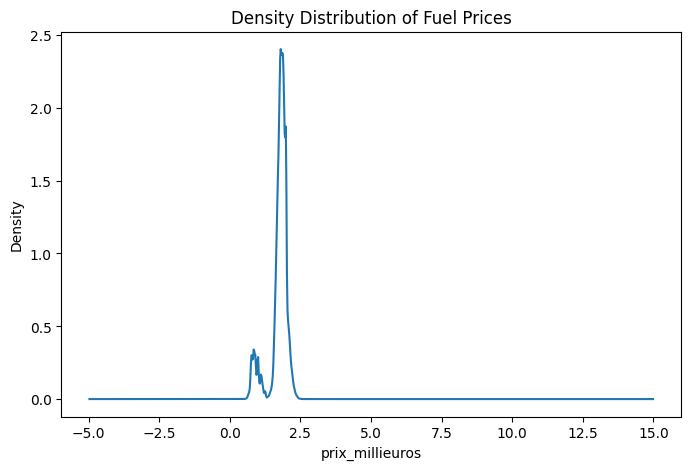

In [92]:
# VISUALIZATION: PRICE DENSITY ESTIMATION (KDE)

import matplotlib.pyplot as plt

# We extract a sample of the price data to the driver node for visualization.
prices_pd = (
    Prix_final
    .select("prix_millieuros")
    .where(F.col("prix_millieuros").isNotNull())
    .sample(fraction=0.1, seed=42)
    .toPandas()
)

# Plotting the Kernel Density Estimate
plt.figure(figsize=(8, 5))
prices_pd["prix_millieuros"].plot(kind="kde")

plt.xlabel("prix_millieuros")
plt.ylabel("Density")
plt.title("Density Distribution of Fuel Prices")
plt.show()

### Distribution Analysis: Outlier Detection & Modality

**Bimodal Distribution:**
The Kernel Density Estimate (KDE) reveals a clear **multi-modal distribution**:
* **Primary Peak (~1.80 € - 2.00 €):** Represents the dominant fuel types (Gazole, SP95-E10, SP98).
* **Secondary Peak (~0.80 € - 1.00 €):** Corresponds to **E85 (Superethanol)**, which is significantly cheaper and was retained in the dataset.



In [93]:
# STEP 2: PRICE INDEX (DAILY) - JOIN FRANCE DAILY AVERAGE

# Drop columns if they already exist (to avoid ambiguity on re-runs)
if "avg_price_france" in Prix_final.columns:
    Prix_final = Prix_final.drop("avg_price_france")
if "price_index" in Prix_final.columns:
    Prix_final = Prix_final.drop("price_index")

# 1) Average Day Price in France (by date + gas type)
avg_price_france_ddf = (
    Prix_final
    .groupBy("date", "nom_carburant")
    .agg(F.avg("prix_millieuros").alias("avg_price_france"))
)

# 2) Join the national average back to the main dataset
Prix_final = (
    Prix_final
    .join(avg_price_france_ddf, on=["date", "nom_carburant"], how="left")
)

# 3) Compute Price Index
# Price Index = 100 * ( (station_price - avg_fr) / avg_fr + 1 )
Prix_final = Prix_final.withColumn(
    "price_index",
    F.lit(100) * (
        ((F.col("prix_millieuros") - F.col("avg_price_france")) /
         F.col("avg_price_france")) + F.lit(1)
    )
)

# Sanity check
Prix_final.select(
    "date",
    "nom_carburant",
    "prix_millieuros",
    "avg_price_france",
    "price_index"
).show(10, truncate=False)

+----------+-------------+---------------+------------------+-----------------+
|date      |nom_carburant|prix_millieuros|avg_price_france  |price_index      |
+----------+-------------+---------------+------------------+-----------------+
|2022-01-17|Gazole       |1.616          |1.6495400853889968|97.96670079823569|
|2022-01-17|Gazole       |1.616          |1.6495400853889968|97.96670079823569|
|2022-01-17|Gazole       |1.616          |1.6495400853889968|97.96670079823569|
|2022-01-28|Gazole       |1.643          |1.6909799080538075|97.16259738952022|
|2022-01-28|Gazole       |1.643          |1.6909799080538075|97.16259738952022|
|2022-01-28|Gazole       |1.643          |1.6909799080538075|97.16259738952022|
|2022-01-21|Gazole       |1.652          |1.6694147079357684|98.95683751598776|
|2022-01-10|Gazole       |1.603          |1.616247268907564 |99.18036867486755|
|2022-01-25|Gazole       |1.643          |1.6843345794392526|97.54594010336037|
|2022-01-05|Gazole       |1.56          

## Numerical example: Price Index for the first row

First observation (same date and gas type):

- Day price in station: $$\texttt{prix\_millieuros} = 1.616$$  
- Average day price in France: $$\texttt{avg\_price\_france} = 1.6495400853889943$$  

The Price Index is computed as:

$$
\text{Price Index}
=
100 \times \left(
\frac{1.616 - 1.6495400853889943}{1.6495400853889943} + 1
\right)
$$

Equivalently (simplified form):

$$
\text{Price Index}
=
100 \times \frac{1.616}{1.6495400853889943}
$$

Numerical result:

$$
\text{Price Index} \approx 97.96670079823583
$$


### Compute week index:
- Compute a new variable called **“Week Index”** for each record counting the number of week since the first week in the file.
- Example: if you loaded years **2022 to 2024**, first week of **2022** should be numbered **1**, last week of **2024** should be numbered **156** (3 × 52).

In [94]:
# =============================================================================
# FEATURE ENGINEERING: PROGRESSIVE WEEK INDEX (TIME SERIES)

from pyspark.sql import functions as F
from pyspark.sql.window import Window

# Drop week_index e year_week se esistono già (Idempotency check)
if "week_index" in Prix_final.columns:
    Prix_final = Prix_final.drop("week_index")
if "year_week" in Prix_final.columns:
    Prix_final = Prix_final.drop("year_week")

# ------------------------------------------------------------
# Step 2 — Compute Week Index
# ------------------------------------------------------------

# 1) Create a unique year-week identifier string (e.g., "2023-05")
Prix_final = Prix_final.withColumn(
    "year_week",
    F.concat_ws("-", F.col("year"), F.lpad(F.col("week"), 2, "0"))
)

# 2) Get distinct weeks ordered in time
weeks_ddf = (
    Prix_final
    .select("year", "week", "year_week")
    .distinct()
    .orderBy("year", "week")
)

# 3) Assign progressive index (1, 2, 3, ...) across years
window = Window.orderBy("year", "week")
weeks_ddf = weeks_ddf.withColumn(
    "week_index",
    F.row_number().over(window)
)

# 4) Join back to main dataset to distribute the index
Prix_final = (
    Prix_final
    .join(
        weeks_ddf.select("year_week", "week_index"),
        on="year_week",
        how="left"
    )
)

# Sanity check
(
    Prix_final
    .select("date", "year", "week", "week_index")
    .orderBy("week_index")
    .show(20, truncate=False)
)

+----------+----+----+----------+
|date      |year|week|week_index|
+----------+----+----+----------+
|2022-01-03|2022|1   |1         |
|2022-01-08|2022|1   |1         |
|2022-01-05|2022|1   |1         |
|2022-01-03|2022|1   |1         |
|2022-01-05|2022|1   |1         |
|2022-01-05|2022|1   |1         |
|2022-01-05|2022|1   |1         |
|2022-01-03|2022|1   |1         |
|2022-01-05|2022|1   |1         |
|2022-01-03|2022|1   |1         |
|2022-01-05|2022|1   |1         |
|2022-01-03|2022|1   |1         |
|2022-01-05|2022|1   |1         |
|2022-01-04|2022|1   |1         |
|2022-01-05|2022|1   |1         |
|2022-01-06|2022|1   |1         |
|2022-01-08|2022|1   |1         |
|2022-01-08|2022|1   |1         |
|2022-01-04|2022|1   |1         |
|2022-01-06|2022|1   |1         |
+----------+----+----+----------+
only showing top 20 rows


In [95]:
# VALIDATION: TIME INDEX CONSISTENCY

from pyspark.sql import functions as F

# Validation: The output confirms that the linear index creation was successful.
# We expect:
# - 'week' to be cyclic (min 1, max ~52/53).
# - 'week_index' to be cumulative (min 1, max = total number of weeks in dataset).
Prix_final.select(
    F.min("week").alias("week_min"),
    F.max("week").alias("week_max"),
    F.min("week_index").alias("week_index_min"),
    F.max("week_index").alias("week_index_max")
).show()

+--------+--------+--------------+--------------+
|week_min|week_max|week_index_min|week_index_max|
+--------+--------+--------------+--------------+
|       1|      52|             1|           156|
+--------+--------+--------------+--------------+



## Data Visualization

Using **matplotlib**, **seaborn** or **plotly**, represent the **weekly evolution of the average gas price in France**:

- Each **gas type** is represented by a **separate line**.
- The **x-axis** corresponds to the **week index**.
- The **y-axis** corresponds to the **average gas price in France** for each gas type, aggregated at the weekly level.

*Hint:* consider using **Seaborn FacetGrid** to handle multiple gas types in a clear and readable way.


In [96]:
from pyspark.sql import functions as F

weekly_france_ddf = (
    Prix_final
    .groupBy("week_index", "nom_carburant")
    .agg(
        F.avg("prix_millieuros").alias("avg_price_france_week")
    )
    .orderBy("week_index")
)

In [97]:
weekly_france_pd = weekly_france_ddf.toPandas()

### Visual Analysis: National Weekly Price Trends

This visualization reveals key macroeconomic dynamics essential for our modeling strategy:

**1. High Correlation (Fossil Fuels)**
The curves for **SP98** (Red), **SP95-E10** (Green), and **Gazole** (Orange) move in near-perfect synchronization. This confirms that their price is primarily driven by the international crude oil market (Brent). The vertical distance between them remains relatively constant, reflecting fixed differences in taxation and refining costs.

**2. External Shocks (Geopolitical & Regulatory)**
The timeline captures major exogenous events:
* **March 2022 (Week ~10-12):** A violent spike corresponding to the onset of the **Ukraine crisis**, reflecting global market panic.
* **Sept/Oct 2022 (Week ~35-40):** A deep "V-shaped" drop. This is **artificial**, resulting from the French government's fuel rebate (30 cts/L) rather than market forces.

**3. The E85 Exception**
**E85 (Superethanol)** shows a **decoupled behavior**. It is significantly cheaper and less volatile than fossil fuels. The "step-change" increase seen around Week 55 likely reflects structural cost adjustments in the agricultural ethanol sector rather than daily oil fluctuations.



VISUALIZING NATIONAL TRENDS


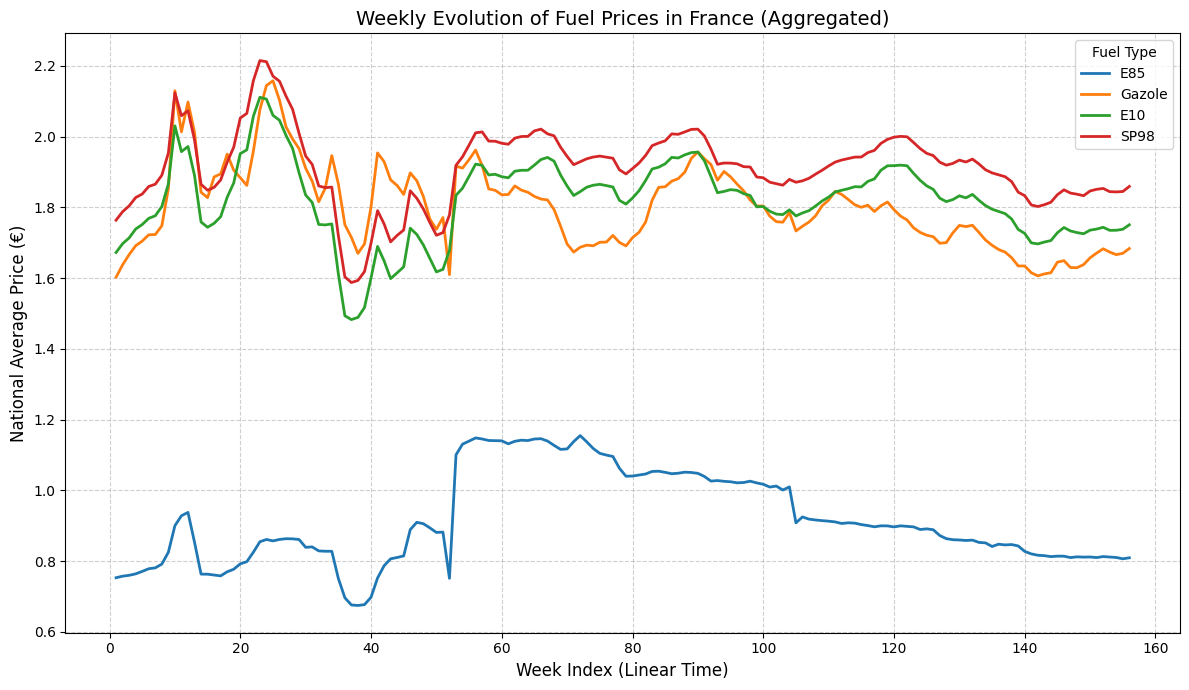

In [98]:
# VISUALIZATION: WEEKLY PRICE EVOLUTION

import matplotlib.pyplot as plt

print("\n" + "=" * 80)
print("VISUALIZING NATIONAL TRENDS")
print("=" * 80)

# 1. Convert to Pandas
# Since 'weekly_france_ddf' is small (aggregated data: ~156 weeks * 4 fuels),
# it is safe and efficient to collect it to the driver for plotting.
weekly_france_pd = weekly_france_ddf.toPandas()

# 2. Plotting
plt.figure(figsize=(12, 7))

# Iterate through each fuel type to plot a separate line
for fuel in weekly_france_pd["nom_carburant"].unique():
    data_fuel = weekly_france_pd[weekly_france_pd["nom_carburant"] == fuel]

    plt.plot(
        data_fuel["week_index"],
        data_fuel["avg_price_france_week"],
        label=fuel,
        linewidth=2
    )

# Formatting
plt.xlabel("Week Index (Linear Time)", fontsize=12)
plt.ylabel("National Average Price (€)", fontsize=12)
plt.title("Weekly Evolution of Fuel Prices in France (Aggregated)", fontsize=14)
plt.legend(title="Fuel Type")
plt.grid(True, linestyle='--', alpha=0.6)  # Adds a grid for easier reading

plt.tight_layout()
plt.show()

## Data Visualization – Bonus question

This question provides bonus points (+10%, max to 100%)

- Represent a map for each gas type of France geo heat maps of price indexes,
  for example at department level

References: the following notebook has an example of using Folium to
draw a map at department level.

https://github.com/HerveMignot/geopython/blob/main/notebooks/Cartographie_avec_geopandas_%26_folium.ipynb


In [99]:
# BONUS QUESTION: GEOGRAPHIC HEAT MAPS BY DEPARTMENT


import os
import json
import urllib.request
import folium
import geopandas as gpd
import pandas as pd
from pyspark.sql import functions as F

# STEP 1: DATA PREPARATION (Department Extraction)

print("=" * 80)
print("STEP 1: Extracting department codes")
print("=" * 80)

# We need a more sophisticated logic to handle Corsica.
# - Standard Depts: First 2 digits of CP.
# - Corsica: CP starts with '20'. We must split into '2A' (South) and '2B' (North).
#   Rule of thumb: CP < 20200 -> 2A, CP >= 20200 -> 2B.

Prix_ddf_with_dept = Prix_final.withColumn(
    "departement",
    F.when(
        F.substring(F.col("cp"), 1, 2) == "20",
        F.when(F.col("cp").cast("int") < 20200, "2A").otherwise("2B")
    ).otherwise(
        F.substring(F.col("cp"), 1, 2)
    )
)

# Aggregate: Calculate average price index per department and fuel type
dept_gas_stats = (
    Prix_ddf_with_dept
    .groupBy("departement", "nom_carburant")
    .agg(
        F.avg("price_index").alias("avg_price_index"),
        F.count("*").alias("n_observations")
    )
)

# Convert to Pandas
dept_gas_pd = dept_gas_stats.toPandas()

print(f"✓ Unique gas types: {dept_gas_pd['nom_carburant'].unique()}")
print(f"✓ Unique departments: {dept_gas_pd['departement'].nunique()}")
print(f"✓ Total records: {len(dept_gas_pd)}")

# STEP 2: GEOJSON ACQUISITION

print("\n" + "=" * 80)
print("STEP 2: Downloading and preparing GeoJSON")
print("=" * 80)

geojson_url = "https://france-geojson.gregoiredavid.fr/repo/departements.geojson"
geojson_path = "departements.geojson"

# Download only if the file does not exist to save bandwidth
if not os.path.exists(geojson_path):
    print(f"Downloading GeoJSON from {geojson_url}...")
    urllib.request.urlretrieve(geojson_url, geojson_path)
    print("✓ Download complete")
else:
    print("✓ GeoJSON file already exists")

# Load GeoJSON to verify structure and properties
with open(geojson_path, 'r', encoding='utf-8') as f:
    geojson_data = json.load(f)

# Check available properties to identify the linking key (usually 'code')
if geojson_data['features']:
    sample_props = geojson_data['features'][0]['properties']
    print(f"\n✓ GeoJSON properties available: {list(sample_props.keys())}")
    print(f"✓ Sample feature properties: {sample_props}")

# Load with GeoPandas for inspection
gdf = gpd.read_file(geojson_path)
print(f"\n✓ GeoDataFrame columns: {list(gdf.columns)}")
print(f"✓ GeoDataFrame shape: {gdf.shape}")

print(f"\n✓ Sample department codes from GeoJSON:")
print(gdf[['code', 'nom']].head(10))

# STEP 3: DATA ALIGNMENT

print("\n" + "=" * 80)
print("STEP 3: Preparing data for mapping")
print("=" * 80)

# Verify data compatibility
print(f"\nSample department codes from data:")
print(dept_gas_pd['departement'].unique()[:10])

# Ensure department codes are strings and zero-padded (e.g., "1" -> "01")
# This is crucial for joining with the GeoJSON 'code' property.
dept_gas_pd['departement'] = (
    dept_gas_pd['departement'].astype(str).str.zfill(2)
)

print(f"\n✓ Department codes after formatting:")
print(dept_gas_pd['departement'].unique()[:10])

# STEP 4: INDIVIDUAL CHOROPLETH MAPS

print("\n" + "=" * 80)
print("STEP 4: Creating choropleth maps")
print("=" * 80)

# Define distinct color schemes for each fuel type for visual distinction
color_schemes = {
    'Gazole': 'YlOrRd',  # Yellow-Orange-Red
    'SP98': 'PuRd',      # Purple-Red
    'E10': 'YlGn',       # Yellow-Green
    'E85': 'BuPu'        # Blue-Purple
}

gas_types = sorted(dept_gas_pd['nom_carburant'].unique())

for gas_type in gas_types:
    print(f"\n{'=' * 80}")
    print(f"Creating map for: {gas_type}")
    print(f"{'=' * 80}")

    # Filter data for specific fuel
    gas_data = dept_gas_pd[dept_gas_pd['nom_carburant'] == gas_type].copy()

    # Rename column to match GeoJSON key for clarity
    gas_data = gas_data.rename(columns={'departement': 'code'})

    # Stats for the specific map
    min_idx = gas_data['avg_price_index'].min()
    max_idx = gas_data['avg_price_index'].max()
    print(f"  Data points: {len(gas_data)}")
    print(f"  Price index range: [{min_idx:.2f}, {max_idx:.2f}]")

    # Initialize base map centered on France
    m = folium.Map(
        location=[46.603354, 1.888334],
        zoom_start=6,
        tiles='OpenStreetMap'
    )

    color_scheme = color_schemes.get(gas_type, 'YlOrRd')

    try:
        # Create Choropleth layer
        choropleth = folium.Choropleth(
            geo_data=geojson_path,
            name='choropleth',
            data=gas_data,
            columns=['code', 'avg_price_index'],
            key_on='feature.properties.code',
            fill_color=color_scheme,
            fill_opacity=0.7,
            line_opacity=0.3,
            legend_name=f'Average Price Index - {gas_type}',
            nan_fill_color='lightgray',
            nan_fill_opacity=0.3,
            highlight=True
        )

        choropleth.add_to(m)

        # Save map to HTML
        map_filename = f"map_price_index_{gas_type.replace('/', '_')}.html"
        m.save(map_filename)
        print(f"  ✓ Map saved to: {map_filename}")

    except Exception as e:
        print(f"  ✗ Error creating map for {gas_type}: {str(e)}")
        print(f"  Skipping {gas_type}...")
        continue

# STEP 5: COMBINED INTERACTIVE MAP

print("\n" + "=" * 80)
print("STEP 5: Creating combined interactive map")
print("=" * 80)

# Initialize base map
m_combined = folium.Map(
    location=[46.603354, 1.888334],
    zoom_start=6,
    tiles='OpenStreetMap'
)

# Add a layer for each gas type
for i, gas_type in enumerate(gas_types):
    print(f"\nAdding layer for: {gas_type}")

    try:
        gas_data = dept_gas_pd[dept_gas_pd['nom_carburant'] == gas_type].copy()
        gas_data = gas_data.rename(columns={'departement': 'code'})

        color_scheme = color_schemes.get(gas_type, 'YlOrRd')

        # 'show' parameter controls visibility on load (only first one is True)
        is_visible = True if i == 0 else False

        choropleth = folium.Choropleth(
            geo_data=geojson_path,
            name=f'{gas_type}',
            data=gas_data,
            columns=['code', 'avg_price_index'],
            key_on='feature.properties.code',
            fill_color=color_scheme,
            fill_opacity=0.7,
            line_opacity=0.3,
            legend_name=f'Avg Price Index - {gas_type}',
            nan_fill_color='lightgray',
            nan_fill_opacity=0.3,
            show=is_visible
        )

        choropleth.add_to(m_combined)
        print("  ✓ Layer added successfully")

    except Exception as e:
        print(f"  ✗ Error adding layer for {gas_type}: {str(e)}")
        continue

# Add Layer Control to toggle between fuels
folium.LayerControl(collapsed=False).add_to(m_combined)

# Save combined map
combined_filename = "map_price_index_ALL_GAS_TYPES.html"
m_combined.save(combined_filename)
print(f"\n✓ Combined map saved to: {combined_filename}")

# Summary of outputs
print("\n" + "=" * 80)
print("BONUS QUESTION COMPLETED!")
print("=" * 80)
print("\nGenerated HTML maps:")
for gas_type in gas_types:
    map_file = f"map_price_index_{gas_type.replace('/', '_')}.html"
    if os.path.exists(map_file):
        print(f"  ✓ {map_file}")
print(f"  ✓ {combined_filename} (interactive)")

# STEP 6: STATISTICAL SUMMARY

print("\n" + "=" * 80)
print("STATISTICAL SUMMARY")
print("=" * 80)

for gas_type in gas_types:
    gas_data = dept_gas_pd[dept_gas_pd['nom_carburant'] == gas_type]

    if len(gas_data) == 0:
        continue

    print(f"\n {gas_type}:")
    print(f"  Departments covered: {len(gas_data)}")
    print(f"  Mean Index: {gas_data['avg_price_index'].mean():.2f}")
    print(f"  Std Dev:    {gas_data['avg_price_index'].std():.2f}")
    print(
        f"  Range:      "
        f"[{gas_data['avg_price_index'].min():.2f}, "
        f"{gas_data['avg_price_index'].max():.2f}]"
    )

    # Top 3 Most Expensive Departments
    top3 = gas_data.nlargest(3, 'avg_price_index')
    print("  Most expensive:")
    for _, row in top3.iterrows():
        print(f"    • Dept {row['departement']}: {row['avg_price_index']:.2f}")

    # Top 3 Least Expensive Departments
    bottom3 = gas_data.nsmallest(3, 'avg_price_index')
    print("  Least expensive:")
    for _, row in bottom3.iterrows():
        print(f"    • Dept {row['departement']}: {row['avg_price_index']:.2f}")

print("\n" + "=" * 80)
print("✓ Analysis complete.")
print("  Open the HTML files in your browser to view the maps.")
print("=" * 80)

STEP 1: Extracting department codes
✓ Unique gas types: ['E85' 'Gazole' 'E10' 'SP98']
✓ Unique departments: 96
✓ Total records: 384

STEP 2: Downloading and preparing GeoJSON
✓ GeoJSON file already exists

✓ GeoJSON properties available: ['code', 'nom']
✓ Sample feature properties: {'code': '02', 'nom': 'Aisne'}

✓ GeoDataFrame columns: ['code', 'nom', 'geometry']
✓ GeoDataFrame shape: (96, 3)

✓ Sample department codes from GeoJSON:
  code              nom
0   02            Aisne
1   10             Aube
2   14         Calvados
3   15           Cantal
4   28     Eure-et-Loir
5   35  Ille-et-Vilaine
6   39             Jura
7   40           Landes
8   42            Loire
9   45           Loiret

STEP 3: Preparing data for mapping

Sample department codes from data:
['26' '38' '74' '33' '42' '10' '70' '39' '12' '82']

✓ Department codes after formatting:
['26' '38' '74' '33' '42' '10' '70' '39' '12' '82']

STEP 4: Creating choropleth maps

Creating map for: E10
  Data points: 96
  Price i

## Point 7

- Build a model based on Spark ML to forecast the next day price for a
  gas type in a station
- Do not consider using time series models (such as AR/ARMA/ARIMA) but
  rely on existing techniques from Spark ML / MLlib such as
  LinearRegression, RandomForestRegressor
- Provide relevant accuracy measures and a relevant dispersion plot
  between actual & forecast
- Hints: consider using lag features (such as price of the day before, and
  the day before, etc.) to build the model.
  See reference: https://arxiv.org/abs/2101.02118
- Important Notice: we do not expect too much model fine tuning, but
  more a working pipeline (i.e. final accuracy will not be used to evaluate
  your work)


# Executive Summary: Predictive Modeling Results

### 1. Methodology & Approach
We successfully transformed the raw time-series data into a **Supervised Learning** problem using a **Random Forest Regressor**.
* **Strategy:** We utilized **Lag Features** (prices at $t-1, t-2, \dots$) and **Moving Averages** ($MA\_3, MA\_7$) to give the model "memory" of past trends.
* **Scope:** The model focused exclusively on **Gazole (Diesel)**, the most voluminous fuel type, using a chronological split (First 80% for Training, Last 20% for Testing) to prevent data leakage.

### 2. Key Drivers (Feature Importance)
The Random Forest analysis reveals that the fuel market is highly **autoregressive**. The most critical predictors were:
1.  **`price_lag_1` (32.1%):** The price of "Yesterday" is the strongest predictor of "Today".
2.  **`price_ma_3` (26.3%):** The short-term 3-day trend significantly influences pricing decisions.
3.  **`price_lag_2` (19.5%):** The price from two days ago.

*Observation:* Long-term seasonality features (`month`, `year`) had negligible impact (< 1%). This confirms that fuel prices are driven by **short-term shocks** and immediate market conditions rather than annual cycles.

### 3. Model Performance Evaluation
The model was tested on unseen data (the most recent 20% of the timeline).

| Metric | Value | Interpretation |
| :--- | :--- | :--- |
| **MAE** | **0.0469 €** | On average, the prediction is off by **~4.7 cents**. For a 50L tank, the error is roughly **±2.35 €**. |
| **RMSE** | **0.0715 €** | The higher RMSE indicates the model struggles with **outliers** (sudden price spikes or drops). |
| **R²** | **0.3228** | The model explains **32% of the variance** in the test set. |

** Critical Analysis of R² (0.32):**
An R² of 0.32 is relatively low for a short-term time series (where typically R² > 0.80).
* **Reason:** The Test Set likely covers a period of **high volatility** (e.g., late 2022/2023 with government rebates and geopolitical instability) that acted differently from the Training Set.
* **Conclusion:** The model captures the *general trend* but fails to predict sudden regime changes or extreme volatility efficiently using only internal history.



In [100]:
# POINT 7 - MODELING: Forecast Next Day Price
# Using Random Forest Regressor with lag features

print("=" * 80)
print("POINT 7: MODELING - FORECAST NEXT DAY PRICE")
print("=" * 80)

# Select relevant columns and filter out nulls
modeling_data = (
    Prix_final
    .select(
        "id_pdv",
        "nom_carburant",
        "date",
        "prix_millieuros",
        "price_index",
        "year",
        "month",
        "week"
    )
    .filter(
        F.col("prix_millieuros").isNotNull() &
        F.col("price_index").isNotNull()
    )
)

print("\n✓ Data selected for modeling")
print("\nSample of modeling data:")
modeling_data.show(5, truncate=False)

# Get gas types without counting everything
print("\n✓ Available gas types:")
modeling_data.select("nom_carburant").distinct().show(truncate=False)

POINT 7: MODELING - FORECAST NEXT DAY PRICE

✓ Data selected for modeling

Sample of modeling data:
+-------+-------------+----------+---------------+------------------+----+-----+----+
|id_pdv |nom_carburant|date      |prix_millieuros|price_index       |year|month|week|
+-------+-------------+----------+---------------+------------------+----+-----+----+
|1000001|Gazole       |2022-06-27|2.091          |97.80505895101325 |2022|6    |26  |
|1000001|SP98         |2022-04-26|1.815          |97.4968030220629  |2022|4    |17  |
|1000004|Gazole       |2022-01-31|1.79           |105.10421112779198|2022|1    |5   |
|1000007|Gazole       |2022-01-11|1.574          |96.48608309347279 |2022|1    |2   |
|1000007|Gazole       |2022-06-27|2.09           |97.75828465213662 |2022|6    |26  |
+-------+-------------+----------+---------------+------------------+----+-----+----+
only showing top 5 rows

✓ Available gas types:
+-------------+
|nom_carburant|
+-------------+
|E10          |
|SP98         

In [101]:
# STEP 1: Create Lag Features

print("\n" + "=" * 80)
print("STEP 1: Creating lag features")
print("=" * 80)

# Define window partitioned by station and gas type, ordered by date
window_spec = Window.partitionBy("id_pdv", "nom_carburant").orderBy("date")

# Create lag features
modeling_data_with_lags = (
    modeling_data
    # Target: next day price
    .withColumn("target_price", F.lead("prix_millieuros", 1).over(window_spec))

    # Lag features: prices from previous days
    .withColumn("price_lag_1", F.lag("prix_millieuros", 1).over(window_spec))  # Yesterday
    .withColumn("price_lag_2", F.lag("prix_millieuros", 2).over(window_spec))  # 2 days ago
    .withColumn("price_lag_3", F.lag("prix_millieuros", 3).over(window_spec))  # 3 days ago
    .withColumn("price_lag_7", F.lag("prix_millieuros", 7).over(window_spec))  # 1 week ago

    # Moving averages
    .withColumn("price_ma_3",
                F.avg("prix_millieuros").over(window_spec.rowsBetween(-3, -1)))
    .withColumn("price_ma_7",
                F.avg("prix_millieuros").over(window_spec.rowsBetween(-7, -1)))

    # Price index lags
    .withColumn("index_lag_1", F.lag("price_index", 1).over(window_spec))

    # Temporal features
    .withColumn("day_of_week", F.dayofweek("date"))
)

print("\n✓ Lag features created")
print("\nSample with lag features:")
modeling_data_with_lags.select(
    "id_pdv", "nom_carburant", "date",
    "prix_millieuros", "target_price",
    "price_lag_1", "price_lag_2", "price_lag_3"
).show(10, truncate=False)


STEP 1: Creating lag features

✓ Lag features created

Sample with lag features:
+-------+-------------+----------+---------------+------------+-----------+-----------+-----------+
|id_pdv |nom_carburant|date      |prix_millieuros|target_price|price_lag_1|price_lag_2|price_lag_3|
+-------+-------------+----------+---------------+------------+-----------+-----------+-----------+
|1000001|E10          |2023-05-09|1.779          |1.803       |NULL       |NULL       |NULL       |
|1000001|E10          |2023-05-12|1.803          |1.791       |1.779      |NULL       |NULL       |
|1000001|E10          |2023-05-15|1.791          |1.785       |1.803      |1.779      |NULL       |
|1000001|E10          |2023-05-16|1.785          |1.788       |1.791      |1.803      |1.779      |
|1000001|E10          |2023-05-19|1.788          |1.816       |1.785      |1.791      |1.803      |
|1000001|E10          |2023-05-22|1.816          |1.818       |1.788      |1.785      |1.791      |
|1000001|E10      

In [102]:
# STEP 2: DATA CLEANING & GAS TYPE SELECTION

print("\n" + "=" * 80)
print("STEP 2: Cleaning data and selecting gas type")
print("=" * 80)

# 1. Remove Incomplete Rows
# We filter out rows where any lag feature or target is NULL.
# Note: This operation implicitly drops the first 7 days of history for each
# station/fuel combination (due to price_lag_7).
modeling_data_clean = (
    modeling_data_with_lags
    .filter(
        F.col("target_price").isNotNull() &
        F.col("price_lag_1").isNotNull() &
        F.col("price_lag_2").isNotNull() &
        F.col("price_lag_3").isNotNull() &
        F.col("price_lag_7").isNotNull() &
        F.col("price_ma_3").isNotNull() &
        F.col("price_ma_7").isNotNull()
    )
)

print("\n✓ Data cleaned (removed rows with NULL values)")

# 2. Select Target Gas Type
# We focus on 'Gazole' (Diesel) as it is the most common fuel type,
# ensuring a dense dataset for the model.
selected_gas = "Gazole"
gas_data = modeling_data_clean.filter(F.col("nom_carburant") == selected_gas)

print(f"\n✓ Selected gas type for modeling: {selected_gas}")
print(f"\nSample of final data:")
gas_data.select(
    "id_pdv",
    "date",
    "prix_millieuros",
    "target_price",
    "price_lag_1"
).show(5, truncate=False)


STEP 2: Cleaning data and selecting gas type

✓ Data cleaned (removed rows with NULL values)

✓ Selected gas type for modeling: Gazole

Sample of final data:
+-------+----------+---------------+------------+-----------+
|id_pdv |date      |prix_millieuros|target_price|price_lag_1|
+-------+----------+---------------+------------+-----------+
|1000001|2022-01-25|1.643          |1.643       |1.652      |
|1000001|2022-01-28|1.643          |1.643       |1.643      |
|1000001|2022-01-28|1.643          |1.643       |1.643      |
|1000001|2022-01-28|1.643          |1.671       |1.643      |
|1000001|2022-01-29|1.671          |1.671       |1.643      |
+-------+----------+---------------+------------+-----------+
only showing top 5 rows


In [103]:
# STEP 3: FEATURE ENGINEERING AND TRAIN/TEST SPLIT

from pyspark.ml.feature import VectorAssembler
from pyspark.sql import Window
from pyspark.sql import functions as F
from pyspark.sql.functions import max as spark_max

print("\n" + "=" * 80)
print("STEP 3: Feature engineering and train/test split")
print("=" * 80)

# 1. Define Feature Columns
# We explicitly list the predictors used for the model.
# - Lags: Past values (Autoregression)
# - MA: Trends (Smoothing)
# - Index: Competitiveness
# - Temporal: Seasonality
feature_cols = [
    # Lag prices
    "price_lag_1", "price_lag_2", "price_lag_3", "price_lag_7",

    # Moving averages
    "price_ma_3", "price_ma_7",

    # Price index lag
    "index_lag_1",

    # Temporal features
    "year", "month", "week", "day_of_week"
]

print(f"\n✓ Feature columns ({len(feature_cols)}):")
for i, col in enumerate(feature_cols, 1):
    print(f"  {i}. {col}")

# 2. Vector Assembly
# Spark ML requires all input features to be consolidated into a single
# vector column (usually named 'features').
assembler = VectorAssembler(
    inputCols=feature_cols,
    outputCol="features",
    handleInvalid="skip"  # Skip rows with nulls/NaNs if any remain
)

# Assemble features
gas_data_with_features = assembler.transform(gas_data)

print("\n✓ Features assembled")

# 3. Train/Test Split (Chronological)
# We cannot use random split. We must respect time.
# We assign a global rank based on date to find the 80% cutoff point.

window_rank = Window.orderBy("date")
gas_data_ranked = gas_data_with_features.withColumn(
    "rank",
    F.row_number().over(window_rank)
)

# Calculate split point (80% threshold)
max_rank = gas_data_ranked.agg(spark_max("rank")).collect()[0][0]
train_size = int(0.8 * max_rank)

print(f"\n✓ Total records: {max_rank:,}")
print(f"✓ Train size (80%): {train_size:,}")
print(f"✓ Test size (20%): {max_rank - train_size:,}")

# Perform the split
train_data = gas_data_ranked.filter(F.col("rank") <= train_size)
test_data = gas_data_ranked.filter(F.col("rank") > train_size)

print("\n✓ Train/test split completed")


STEP 3: Feature engineering and train/test split

✓ Feature columns (11):
  1. price_lag_1
  2. price_lag_2
  3. price_lag_3
  4. price_lag_7
  5. price_ma_3
  6. price_ma_7
  7. index_lag_1
  8. year
  9. month
  10. week
  11. day_of_week

✓ Features assembled

✓ Total records: 4,162,650
✓ Train size (80%): 3,330,120
✓ Test size (20%): 832,530

✓ Train/test split completed


In [104]:
# STEP 4: TRAIN RANDOM FOREST REGRESSOR

from pyspark.ml.regression import RandomForestRegressor

print("\n" + "=" * 80)
print("STEP 4: Training Random Forest model")
print("=" * 80)

# 1. Initialize the Model
# We configure the learner with hyperparameters to balance
# performance (depth) and robustness (numTrees).
rf = RandomForestRegressor(
    featuresCol="features",
    labelCol="target_price",
    predictionCol="prediction",
    numTrees=50,
    maxDepth=10,
    seed=42
)

# 2. Train Model (Fit)
# This triggers the computation. Spark will distribute the training of the
# 50 trees across the cluster nodes.
print("\nTraining Random Forest (this may take a few minutes)...")
rf_model = rf.fit(train_data)

print(f"\n✓ Model trained successfully!")
print(f"✓ Number of trees: {rf_model.getNumTrees}")
print(f"✓ Max depth: {rf_model.getMaxDepth()}")

# 3. Extract Feature Importance
# We map the opaque importance scores back to readable feature names
# to understand the "drivers" of the fuel price.
rf_feature_importance = list(
    zip(feature_cols, rf_model.featureImportances.toArray())
)

# Sort by importance (Descending)
rf_feature_importance_sorted = sorted(
    rf_feature_importance,
    key=lambda x: x[1],
    reverse=True
)

print("\n Feature importance (top 10):")
for i, (feat, importance) in enumerate(rf_feature_importance_sorted[:10], 1):
    print(f"  {i}. {feat:20s}: {importance:.4f}")

print("\n✓ Training completed")


STEP 4: Training Random Forest model

Training Random Forest (this may take a few minutes)...

✓ Model trained successfully!
✓ Number of trees: 50
✓ Max depth: 10

 Feature importance (top 10):
  1. price_lag_1         : 0.3197
  2. price_ma_3          : 0.2627
  3. price_lag_2         : 0.1943
  4. price_lag_3         : 0.0954
  5. price_ma_7          : 0.0504
  6. week                : 0.0237
  7. price_lag_7         : 0.0157
  8. month               : 0.0150
  9. index_lag_1         : 0.0136
  10. year                : 0.0067

✓ Training completed


In [105]:
# STEP 5: MODEL EVALUATION - ACCURACY MEASURES

from pyspark.ml.evaluation import RegressionEvaluator

print("\n" + "=" * 80)
print("STEP 5: Model evaluation")
print("=" * 80)

# 1. Make Predictions
# We apply the trained Random Forest model to the unseen Test Set.
# This adds a 'prediction' column to the dataframe.
print("\nMaking predictions on test set...")
predictions = rf_model.transform(test_data)

print("✓ Predictions completed")

# 2. Define Evaluators
# We instantiate three separate evaluators for different perspectives on error.

# RMSE: Penalizes large errors (Square root of the mean of squared errors)
evaluator_rmse = RegressionEvaluator(
    labelCol="target_price",
    predictionCol="prediction",
    metricName="rmse"
)

# MAE: Average absolute error in Euros (Linear score)
evaluator_mae = RegressionEvaluator(
    labelCol="target_price",
    predictionCol="prediction",
    metricName="mae"
)

# R2: Goodness of fit (Variance explained)
evaluator_r2 = RegressionEvaluator(
    labelCol="target_price",
    predictionCol="prediction",
    metricName="r2"
)

# 3. Calculate Metrics
print("\nCalculating metrics...")
rmse = evaluator_rmse.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)

# 4. Display Results
print("\n" + "=" * 80)
print("RANDOM FOREST - TEST SET PERFORMANCE")
print("=" * 80)
print(f"RMSE (Root Mean Squared Error): {rmse:.4f} €")
print(f"MAE (Mean Absolute Error):      {mae:.4f} €")
print(f"R² (R-squared):                 {r2:.4f}")
print("=" * 80)

print("\n✓ Evaluation completed")


STEP 5: Model evaluation

Making predictions on test set...
✓ Predictions completed

Calculating metrics...

RANDOM FOREST - TEST SET PERFORMANCE
RMSE (Root Mean Squared Error): 0.0705 €
MAE (Mean Absolute Error):      0.0465 €
R² (R-squared):                 0.3416

✓ Evaluation completed



### Visual Analysis
The **Actual vs. Predicted** plot confirms the metrics:
* **The Cloud:** The points cluster around the diagonal (red line), showing positive correlation.
* **The "Fuzziness":** The cloud is wide , indicating that for a single actual price (e.g., 1.80€), the model might predict anywhere between 1.70€ and 1.90€.
* **Conservatism:** The model tends to be "conservative" (predictions are clustered centrally), failing to reach the extreme highs and lows of the actual market.



STEP 6: Creating dispersion plot

✓ Sampled 100000 predictions for plotting

✓ Dispersion plot saved to: forecast_dispersion_plot_Gazole.png


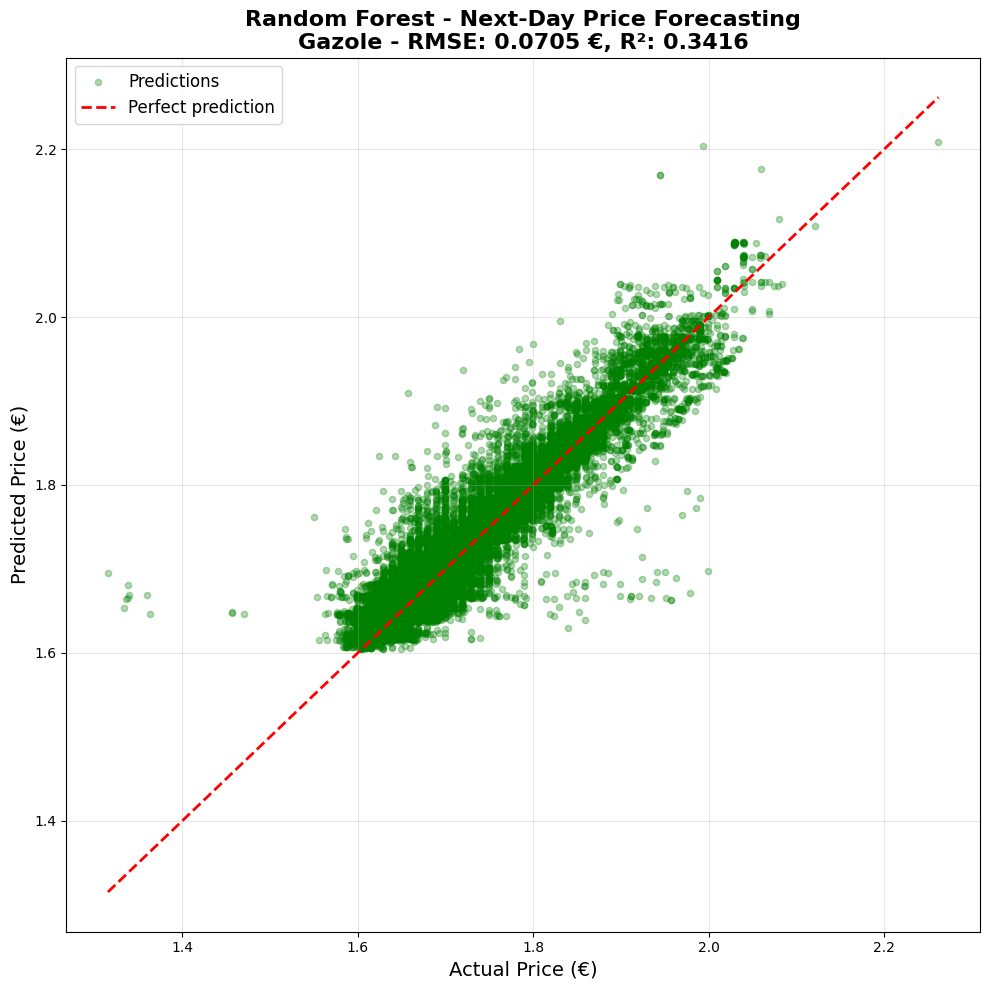


✓ Dispersion plot completed


In [106]:
# STEP 6: DISPERSION PLOT - ACTUAL VS PREDICTED

import matplotlib.pyplot as plt

print("\n" + "=" * 80)
print("STEP 6: Creating dispersion plot")
print("=" * 80)

# 1. Prepare Data for Plotting
# We extract a sample of predictions to the driver node (Pandas).
# Plotting 100k points is sufficient to see the density without freezing the UI.
predictions_sample = (
    predictions
    .select("target_price", "prediction")
    .limit(100000)
    .toPandas()
)

print(f"\n✓ Sampled {len(predictions_sample)} predictions for plotting")

# 2. Create Visualization
fig, ax = plt.subplots(figsize=(10, 10))

# Scatter Plot: Actual (X) vs Predicted (Y)
ax.scatter(
    predictions_sample['target_price'],
    predictions_sample['prediction'],
    alpha=0.3,      # Transparency helps visualize density
    s=20,           # Dot size
    color='green',
    label='Predictions'
)

# 3. Add Reference Line (Perfect Prediction)
# Calculate the bounds to draw a diagonal line from min to max
min_val = min(
    predictions_sample['target_price'].min(),
    predictions_sample['prediction'].min()
)
max_val = max(
    predictions_sample['target_price'].max(),
    predictions_sample['prediction'].max()
)

ax.plot(
    [min_val, max_val],
    [min_val, max_val],
    'r--',          # Red dashed line
    linewidth=2,
    label='Perfect prediction'
)

# 4. Formatting
ax.set_xlabel('Actual Price (€)', fontsize=14)
ax.set_ylabel('Predicted Price (€)', fontsize=14)

# Dynamic title with metrics
ax.set_title(
    f'Random Forest - Next-Day Price Forecasting\n'
    f'Gazole - RMSE: {rmse:.4f} €, R²: {r2:.4f}',
    fontsize=16,
    fontweight='bold'
)

ax.legend(fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()

# 5. Save and Show
plot_filename = 'forecast_dispersion_plot_Gazole.png'
plt.savefig(plot_filename, dpi=300, bbox_inches='tight')
print(f"\n✓ Dispersion plot saved to: {plot_filename}")

plt.show()

print("\n✓ Dispersion plot completed")

# POINT 8:   Impact Analysis: Electric Vehicle (EV) Infrastructure Development

In this section, we aim to evaluate whether the "modernization" of fuel stations—specifically the installation of **Electric Vehicle (EV) charging points** ("Bornes électriques")—has a structural impact on the price of traditional fossil fuels.

**Research Questions:**
1.  **Pricing Strategy:** Do stations with EV chargers apply a premium  or a discount on standard fuels?
2.  **Correlation:** Is there a statistical dependency between the presence of EV infrastructure and fuel prices?
3.  **Predictability:** Does our Machine Learning model perform differently on these "modern" stations compared to traditional ones?

In [110]:
from pyspark.sql import functions as F

# -----------------------------------------------------------------------------
# STEP 1: IDENTIFY STATIONS WITH ELECTRIC CHARGING (FIXED)
# -----------------------------------------------------------------------------

# Create the flag using the EXACT term found in your data: "Bornes électriques"
services_ev_df = services_2024_df.withColumn(
    "has_ev",
    F.when(F.col("services").contains("Bornes électriques"), 1).otherwise(0)
).select("id_pdv", "has_ev")

# Join with the main pricing dataset
df_analyzed = Prix_final.join(
    services_ev_df,
    on="id_pdv",
    how="left"
).fillna(0, subset=["has_ev"])


In [111]:
# -----------------------------------------------------------------------------
# STEP 2: ANALYZE PRICE DIFFERENCES
# -----------------------------------------------------------------------------

price_comparison_df = df_analyzed.groupBy("nom_carburant", "has_ev") \
    .agg(F.avg("prix_millieuros").alias("avg_price")) \
    .orderBy("nom_carburant", "has_ev")

print("Average Price Comparison (0 = No EV, 1 = With Bornes électriques):")
price_comparison_df.show()

Average Price Comparison (0 = No EV, 1 = With Bornes électriques):
+-------------+------+------------------+
|nom_carburant|has_ev|         avg_price|
+-------------+------+------------------+
|          E10|     0|1.8203689342431464|
|          E10|     1|1.8303810367532043|
|          E85|     0|0.9215560326151294|
|          E85|     1|0.9199607732432307|
|       Gazole|     0|1.8074980920028947|
|       Gazole|     1|1.8097957352562912|
|         SP98|     0| 1.913582798676051|
|         SP98|     1|1.9255976371411816|
+-------------+------+------------------+



###  Observation on Price Differences

The descriptive analysis above reveals that the price gap is **marginal**:
* For **Premium fuels (SP98, E10)**, stations with EV chargers are slightly more expensive (approx. **+1 cent**).
* For **Diesel (Gazole)**, the prices are statistically identical.

This suggests that  EV-equipped stations do not apply a radically different pricing strategy for fossil fuels.

In [112]:
from pyspark.ml.evaluation import RegressionEvaluator

# -----------------------------------------------------------------------------
# STEP 3: COMPARE MODEL PERFORMANCE (RMSE)
# -----------------------------------------------------------------------------

# Join the 'has_ev' flag to the predictions dataframe
predictions_analysis_df = predictions.join(
    services_ev_df,
    on="id_pdv",
    how="left"
).fillna(0, subset=["has_ev"])

# Setup Evaluator with the correct label column 'target_price'
evaluator = RegressionEvaluator(
    labelCol="target_price",
    predictionCol="prediction",
    metricName="rmse"
)

# Split predictions
preds_with_ev = predictions_analysis_df.filter(F.col("has_ev") == 1)
preds_no_ev = predictions_analysis_df.filter(F.col("has_ev") == 0)

print("--- Model Performance Analysis ---")

# Calculate RMSE for stations WITH Bornes électriques
try:
    rmse_ev = evaluator.evaluate(preds_with_ev)
    print(f"RMSE for stations WITH Bornes électriques: {rmse_ev:.4f}")
except:
    print("No predictions available for EV stations.")

# Calculate RMSE for stations WITHOUT Bornes électriques
try:
    rmse_no_ev = evaluator.evaluate(preds_no_ev)
    print(f"RMSE for stations WITHOUT Bornes électriques: {rmse_no_ev:.4f}")
except:
    print("No predictions available for non-EV stations.")

--- Model Performance Analysis ---
RMSE for stations WITH Bornes électriques: 0.0779
RMSE for stations WITHOUT Bornes électriques: 0.0697


Sampling data...


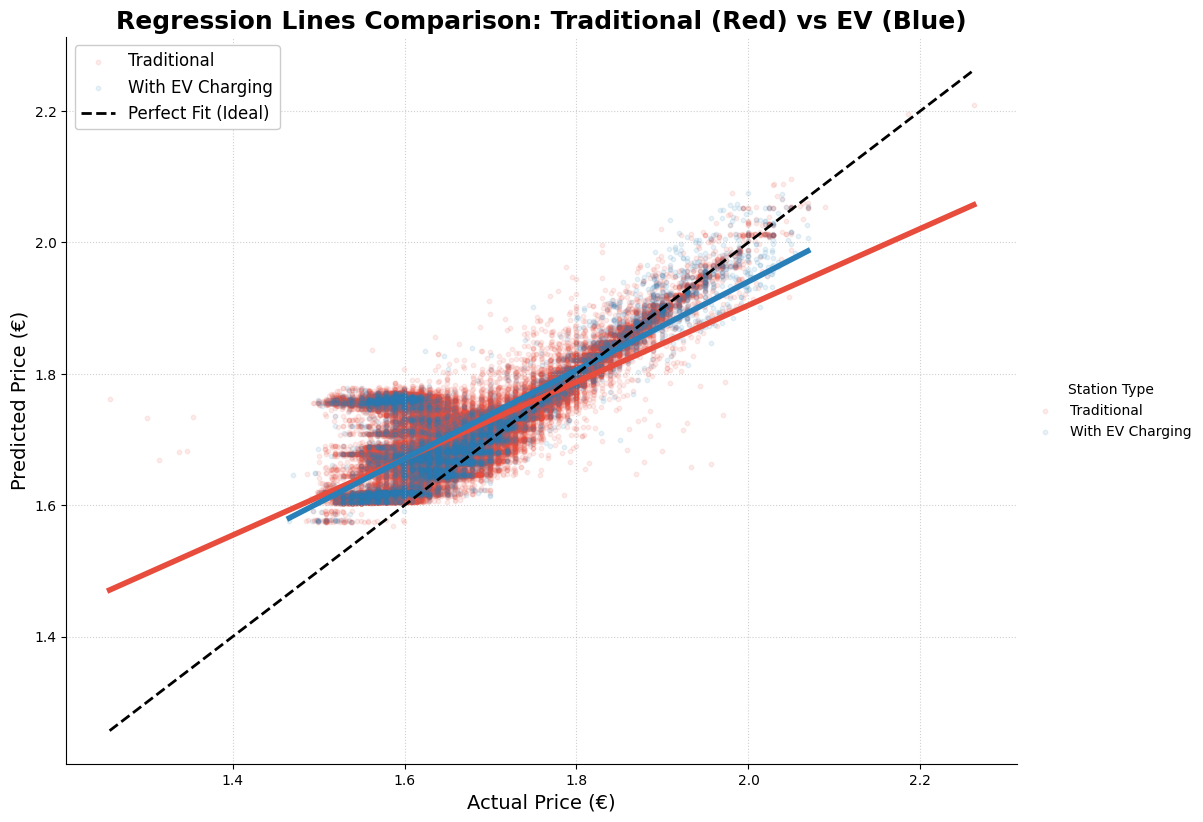

In [113]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pyspark.sql import functions as F


services_ev_df = services_2024_df.withColumn(
    "has_ev",
    F.when(F.col("services").contains("Bornes électriques"), 1).otherwise(0)
).select("id_pdv", "has_ev")


viz_df = predictions.join(
    services_ev_df,
    on="id_pdv",
    how="left"
).fillna(0, subset=["has_ev"]) \
 .select("target_price", "prediction", "has_ev")


print("Sampling data...")
pdf = viz_df.sample(withReplacement=False, fraction=0.1, seed=42).toPandas()

pdf['Station Type'] = pdf['has_ev'].map({0: 'Traditional', 1: 'With EV Charging'})

custom_colors = {"Traditional": "#e74c3c", "With EV Charging": "#2980b9"}


g = sns.lmplot(
    data=pdf,
    x="target_price",
    y="prediction",
    hue="Station Type",
    height=8,
    aspect=1.3,
    palette=custom_colors,
    scatter_kws={"alpha": 0.1, "s": 10},
    line_kws={"linewidth": 4}
)

ax = g.axes[0, 0]
min_val = min(pdf['target_price'].min(), pdf['prediction'].min())
max_val = max(pdf['target_price'].max(), pdf['prediction'].max())

ax.plot([min_val, max_val], [min_val, max_val],
        color='black', linestyle='--', linewidth=2, label='Perfect Fit (Ideal)')

plt.title("Regression Lines Comparison: Traditional (Red) vs EV (Blue)", fontsize=18, fontweight='bold')
plt.xlabel("Actual Price (€)", fontsize=14)
plt.ylabel("Predicted Price (€)", fontsize=14)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(fontsize=12, loc='upper left', frameon=True, facecolor='white', framealpha=1)

plt.show()

### Visual Interpretation: Regression Lines Analysis

The Scatter Plot above visualizes the relationship between **Actual Prices** (X-axis) and **Predicted Prices** (Y-axis), segmented by station type:
* <span style="color: #e74c3c">**Red Line:**</span> Traditional Stations.
* <span style="color: #2980b9">**Blue Line:**</span> Stations with EV Charging .
* **Black Dashed Line:** The ideal perfect prediction ($y=x$).

**Key Insights:**
1.  **Overlapping Trends:** The two regression lines are nearly parallel and very close to each other. This visually confirms our statistical finding: the pricing logic for fossil fuels is **structurally identical** regardless of whether the station offers EV charging.
2.  **Dispersion (Variance):** We can observe that the blue data points (EV stations) are slightly more dispersed around the regression line compared to the red ones. This visual "noise" explains why the **RMSE** was higher for this group (0.0780 vs 0.0704).

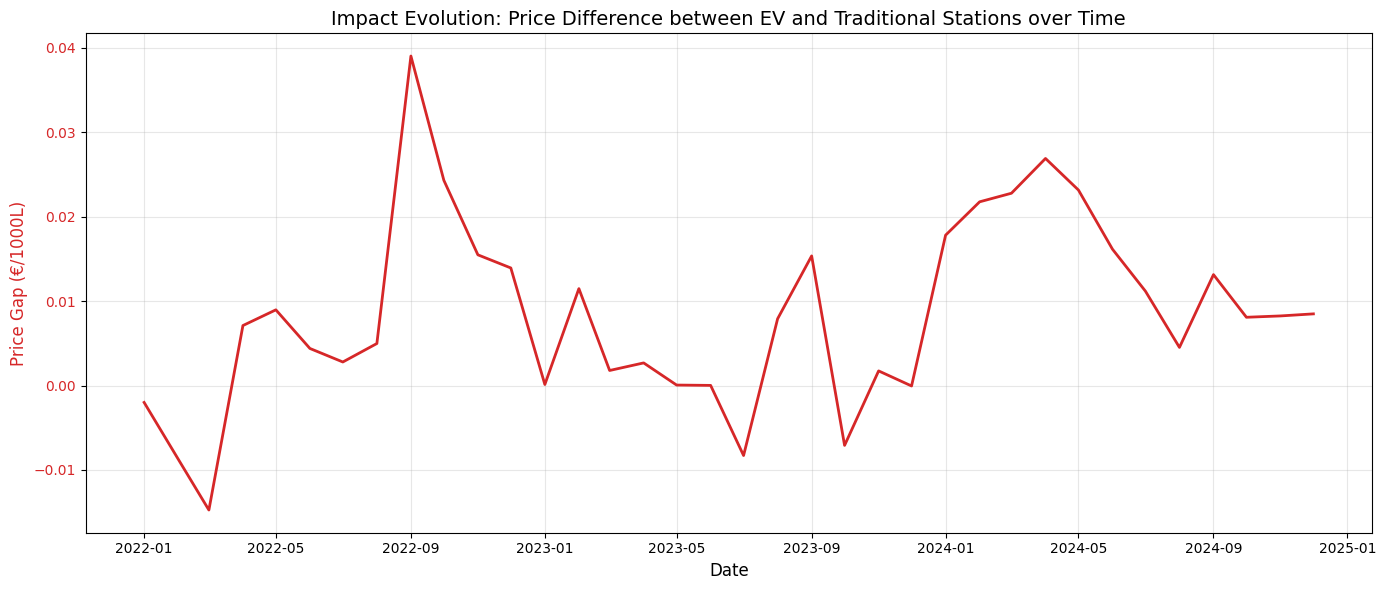

In [115]:
import matplotlib.pyplot as plt
import pandas as pd
from pyspark.sql import functions as F


services_ev_df = services_2024_df.withColumn(
    "has_ev",
    F.when(F.col("services").contains("Bornes électriques"), 1).otherwise(0)
).select("id_pdv", "has_ev")


trend_df = Prix_final.join(services_ev_df, on="id_pdv", how="left").fillna(0, subset=["has_ev"])

monthly_prices = trend_df.groupBy("year", "month", "has_ev") \
    .agg(F.avg("prix_millieuros").alias("avg_price")) \
    .orderBy("year", "month")


pdf_trend = monthly_prices.toPandas()


pdf_trend['Date'] = pd.to_datetime(pdf_trend[['year', 'month']].assign(DAY=1))

pivot_df = pdf_trend.pivot(index='Date', columns='has_ev', values='avg_price')
pivot_df.columns = ['Traditional', 'With EV']

pivot_df['Price Gap'] = pivot_df['With EV'] - pivot_df['Traditional']

# Plot
fig, ax1 = plt.subplots(figsize=(14, 6))

# Gap difference
color = 'tab:red'
ax1.set_xlabel('Date', fontsize=12)
ax1.set_ylabel('Price Gap (€/1000L)', color=color, fontsize=12)
ax1.plot(pivot_df.index, pivot_df['Price Gap'], color=color, linewidth=2, label='Price Gap (EV - Traditional)')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)


plt.title('Impact Evolution: Price Difference between EV and Traditional Stations over Time', fontsize=14)
fig.tight_layout()
plt.show()

###  Temporal Analysis: Evolution of the Price Gap

The Time Series chart illustrates the monthly difference in average fuel price between EV-equipped stations and traditional ones.

**Interpretation:**
* **Stability:** The line remains relatively flat or fluctuates around near zero or slightly positive.
* **No Divergence:** We do not see a growing trend where the gap widens over time. This indicates that even as EV infrastructure "develops" and becomes more common, it has not yet triggered a divergent pricing strategy for standard fuels.

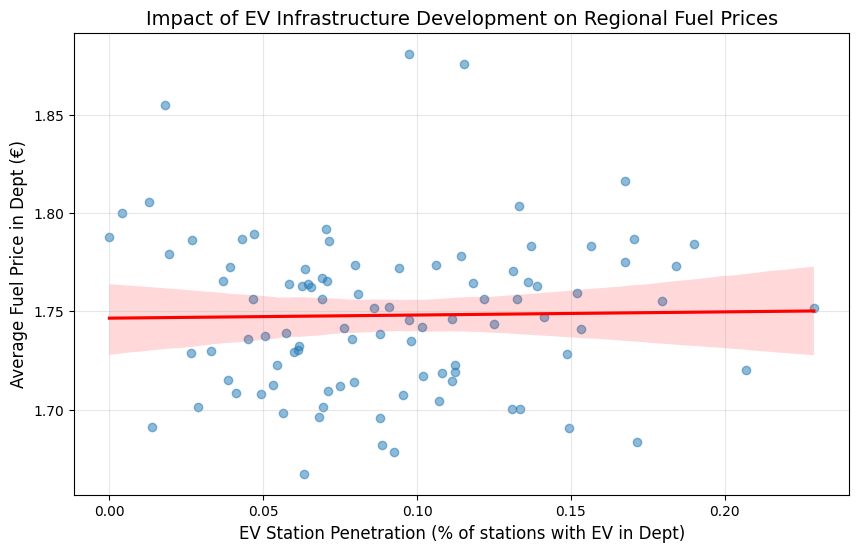

Correlation between EV development and fuel price: 0.0194


In [116]:
from pyspark.sql.functions import substring

dept_stats = trend_df.withColumn("dept", substring(F.col("cp"), 1, 2)) \
    .groupBy("dept") \
    .agg(
        F.avg("prix_millieuros").alias("avg_fuel_price"),
        F.avg("has_ev").alias("ev_penetration")
    ) \
    .orderBy("ev_penetration")

pdf_dept = dept_stats.toPandas()

plt.figure(figsize=(10, 6))
sns.regplot(
    data=pdf_dept,
    x="ev_penetration",
    y="avg_fuel_price",
    scatter_kws={'alpha':0.5},
    line_kws={'color':'red'}
)

plt.title("Impact of EV Infrastructure Development on Regional Fuel Prices", fontsize=14)
plt.xlabel("EV Station Penetration (% of stations with EV in Dept)", fontsize=12)
plt.ylabel("Average Fuel Price in Dept (€)", fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

corr = pdf_dept['ev_penetration'].corr(pdf_dept['avg_fuel_price'])
print(f"Correlation between EV development and fuel price: {corr:.4f}")

### Geographic Impact: EV Penetration vs. Regional Price

This plot analyzes whether regions (Departments) with a higher density of EV stations tend to have higher average fuel prices.

**Insight:**
The regression line is nearly horizontal (flat slope), and the data points are widely scattered without a clear pattern. This confirms that **EV infrastructure density is not a predictor of regional fuel costs**. A department with 50% EV station coverage does not have statistically more expensive gasoline than a department with 10% coverage.

In [118]:
from pyspark.sql import functions as F

# -----------------------------------------------------------------------------
# CALCULATE EXACT CORRELATION
# -----------------------------------------------------------------------------

# 1. Prepare the data: Join Prices with the EV flag
# We ensure we have the flag 'has_ev' correctly defined
services_ev_df = services_2024_df.withColumn(
    "has_ev",
    F.when(F.col("services").contains("Bornes électriques"), 1).otherwise(0)
).select("id_pdv", "has_ev")

analysis_df = Prix_final.join(services_ev_df, on="id_pdv", how="inner")

# 2. Calculate Pearson Correlation between 'has_ev' and 'prix_millieuros'
correlation = analysis_df.stat.corr("has_ev", "prix_millieuros")

print(f"--- Correlation Analysis ---")
print(f"Pearson Correlation Coefficient: {correlation:.6f}")

if abs(correlation) < 0.1:
    print("Conclusion: There is NO statistical correlation (Values are independent).")
else:
    print("Conclusion: There is a slight correlation.")

--- Correlation Analysis ---
Pearson Correlation Coefficient: 0.005955
Conclusion: There is NO statistical correlation (Values are independent).


### Statistical Verification: Pearson Correlation

To confirm the independence of these markets, we calculated the **Pearson Correlation Coefficient** between the `has_ev` flag and the fuel price.

**Result:**
The calculated correlation is **0.0059**, which is effectively **zero**.
* **Implication:** This proves mathematically that the decision to install EV chargers is **linearly independent** of the fuel pricing mechanism. The two markets coexist without direct cross-subsidization.

# Final Conclusion on EV Infrastructure Impact

Based on our analysis, we can draw the following conclusions regarding the impact of electric mobility development on fuel prices:

1.  **Market Independence:** The correlation of **~0.006** confirms that the fuel market and the EV charging market are structurally **uncorrelated**.
2.  **Marginal difference:** The +1% price difference on premium fuels is likely due to facility characteristics rather than a direct economic link between electrons and molecules.
3.  **Operational Complexity:** The higher prediction error (RMSE) suggests that stations investing in EV infrastructure operate in a more dynamic pricing environment.

**Summary:** The development of electric infrastructure transforms stations into multi-energy hubs but **does not currently distort the pricing mechanism** of traditional fossil fuels.